# Uczenie maszynowe
## Lista 3: Indukcja drzew decyzyjnych za pomocą C4.5 (C5.0)

**Autor:** Patryk Rygiel (250080)  
**GitHub:** https://github.com/PatRyg99/ML-PWR-2022

In [276]:
library(repr)
library(ggplot2)
library(MLmetrics)
library(RWeka)
library(C50)
library(caret)

# Utilities

In [475]:
C45.CV <- function(control, data, numFolds, stratify) {
    if (stratify) {
        cvFolds <- createFolds(factor(data$class), numFolds, returnTrain = T)
    } else {
        cvFolds <- createFolds(1:nrow(data), numFolds, returnTrain = T)
    }
        
    scores <- c()

    for (cvFold in cvFolds) {
        trainData <- data[cvFold, ]
        testData <- data[-cvFold, ]
        
        fit.C45 <- J48(class~., data=trainData, control=control)
        predictions <- predict(fit.C45, testData)

        score <- confusionMatrix(predictions, testData$class)[["byClass"]][ , "Balanced Accuracy"]
        score <- mean(unlist(score))
        scores <- c(scores, score)
    }
    
    return (scores)
}

C45.tuning <- function(seed, data, numFolds, confidenceFactorList, leafNumInstancesList, stratify) {
    set.seed(seed)
    
    confidenceFactorCol = c()
    leafNumInstancesCol = c()
    scoreCol = c()
    
    for (confidenceFactor in confidenceFactorList) {
        for (leafNumInstances in leafNumInstancesList) {
            
            if (confidenceFactor == "unpruned") {
                control <- Weka_control(M=leafNumInstances, U=TRUE)
            } else {
                control <- Weka_control(M=leafNumInstances, C=confidenceFactor)
            }
            
            scores <- C45.CV(control, data, numFolds, stratify)

            for (score in scores) {
                confidenceFactorCol <- c(confidenceFactorCol, confidenceFactor)
                leafNumInstancesCol <- c(leafNumInstancesCol, leafNumInstances)
                scoreCol <- c(scoreCol, score)
            }
        }
    }

    df <- data.frame(
        confidence.factor = unlist(confidenceFactorCol),
        leaf.num.instances = as.factor(unlist(leafNumInstancesCol)),
        Balanced.Accuracy = unlist(scoreCol)
    )
    
    return (df)
}

C45.tuning.boxplot <- function(results) {
    plot <- ggplot(results, aes(x=confidence.factor, y=Balanced.Accuracy, fill=leaf.num.instances))
    plot <- plot + geom_boxplot() + theme(text = element_text(size = 16))  
    plot <- plot + labs(title = "Tuning grid search results for C4.5 with 10-fold stratified CV")
    return (plot)
}

In [478]:
C50.CV <- function(control, data, numFolds, stratify) {
    if (stratify) {
        cvFolds <- createFolds(factor(data$class), numFolds, returnTrain = T)
    } else {
        cvFolds <- createFolds(1:nrow(data), numFolds, returnTrain = T)
    }
        
    scores <- c()

    for (cvFold in cvFolds) {
        trainData <- data[cvFold, ]
        testData <- data[-cvFold, ]

        fit.C50 <- C5.0(class~., data=trainData, control=control)
        predictions <- predict(fit.C50, testData)

        score <- confusionMatrix(predictions, testData$class)[["byClass"]][ , "Balanced Accuracy"]
        score <- mean(unlist(score))
        scores <- c(scores, score)

    }
    
    return (scores)
}

C50.tuning <- function(
    seed, data, numFolds, confidenceFactorList, 
    leafNumInstancesList, winnow, stratify
) {
    set.seed(seed)
    
    confidenceFactorCol = c()
    leafNumInstancesCol = c()
    scoreCol = c()
    
    for (confidenceFactor in confidenceFactorList) {
        for (leafNumInstances in leafNumInstancesList) {
            
            control <- C5.0Control(CF=confidenceFactor, winnow=winnow, minCases=leafNumInstances)
            scores <- C50.CV(control, data, numFolds, stratify)

            for (score in scores) {
                confidenceFactorCol <- c(confidenceFactorCol, confidenceFactor)
                leafNumInstancesCol <- c(leafNumInstancesCol, leafNumInstances)
                scoreCol <- c(scoreCol, score)
            }
        }
    }

    df <- data.frame(
        confidence.factor = as.factor(unlist(confidenceFactorCol)),
        leaf.num.instances = as.factor(unlist(leafNumInstancesCol)),
        Balanced.Accuracy = unlist(scoreCol)
    )
    
    return (df)
}

C50.tuning.boxplot <- function(results) {
    plot <- ggplot(results, aes(x=confidence.factor, y=Balanced.Accuracy, fill=leaf.num.instances))
    plot <- plot + geom_boxplot() + theme(text = element_text(size = 16))  
    plot <- plot + labs(title = "Tuning grid search results for C5.0 with 10-fold stratified CV")
    return (plot)
}

In [477]:
decision.tree.comparison <- function(seed, data, C45control, C50control, numFolds) {
    set.seed(seed)
    
    modelCol = c()
    stratifyCol = c()
    scoreCol = c()
    
    for (stratify in c(TRUE, FALSE)) {
            
        scores <- C45.CV(C45control, data, numFolds, stratify)
        for (score in scores) {
            modelCol <- c(modelCol, "C4.5")
            stratifyCol <- c(stratifyCol, stratify)
            scoreCol <- c(scoreCol, score)
        }
        
        scores <- C50.CV(C50control, data, numFolds, stratify)
        for (score in scores) {
            modelCol <- c(modelCol, "C5.0")
            stratifyCol <- c(stratifyCol, stratify)
            scoreCol <- c(scoreCol, score)
        }
    }

    df <- data.frame(
        model = as.factor(unlist(modelCol)),
        cv.stratified = as.factor(unlist(stratifyCol)),
        Balanced.Accuracy = unlist(scoreCol)
    )
    
    return (df)
}

decision.tree.comparison.boxplot <- function(results) {
    plot <- ggplot(results, aes(x=model, y=Balanced.Accuracy, fill=cv.stratified))
    plot <- plot + geom_boxplot() + theme(text = element_text(size = 16))  
    plot <- plot + labs(title = "Comparison between tuned C4.5 and C5.0 with 10-fold CV")
    return (plot)
}

# IRIS

## 1. Ładowanie zbioru danych

In [454]:
irisData <- read.csv("zbiory/iris.data", header=FALSE)
colnames(irisData) <- c("sepal.length", "sepal.width", "petal.length", "petal.width", "class")

head(irisData)

,sepal.length,sepal.width,petal.length,petal.width,class
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
6,5.4,3.9,1.7,0.4,Iris-setosa


## 2. Analiza algorytmu C4.5

### 2.1 Uruchomienie dla domyślnych parametrów

In [455]:
trainRowNumbers <- createDataPartition(irisData$class, p = 0.7, list = FALSE)

trainData <- irisData[trainRowNumbers, ]
testData <- irisData[-trainRowNumbers, ]

In [382]:
fit.C45 <- J48(class~., data=trainData)
predictions <- predict(fit.C45, testData)

confusionMatrix(predictions, testData$class)

Confusion Matrix and Statistics

                 Reference
Prediction        Iris-setosa Iris-versicolor Iris-virginica
  Iris-setosa              15               0              0
  Iris-versicolor           0              14              1
  Iris-virginica            0               1             14

Overall Statistics
                                          
               Accuracy : 0.9556          
                 95% CI : (0.8485, 0.9946)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9333          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Iris-setosa Class: Iris-versicolor
Sensitivity                      1.0000                 0.9333
Specificity                      1.0000                 0.9667
Pos Pred Value                   1.0000                 0.9333
Neg Pred Value

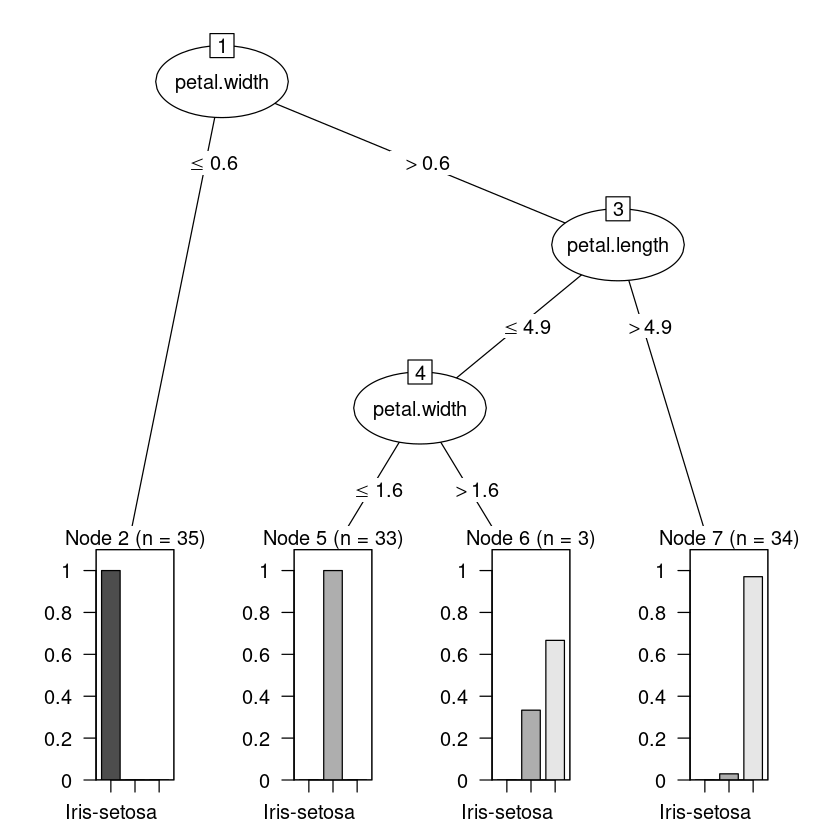

In [5]:
plot(fit.C45)

Klasyfikacja przy użyciu metody C4.5 osiąga całkiem dobre rezultaty dla zbioru Iris: accuracy ~ 95%. Analizując wyrysowane drzewo, możemy zauważyć, że klasyfikacja odbywa się tylko na podstawie dwóch cech (petal-width oraz petal-length), cechy sepal nie są w ogólne brane pod uwagę.

### 2.2 Strojenie parametrów

Do porównania modeli będziemy używać metryki `Balanced Accuracy`:

$\text{Accuracy}_{\text{balanced}} = \frac{(\text{Sensitivity} + \text{Specificity})}{2}$

Ta odmiana metryki `Accuracy` radzi sobie dobrze z niezbalansowanymi klasami w porównaniu do wersji podstawowej.

Parametry do strojenia dla C4.5:
* *confidence factor* - poziom błędu przy, którym przycinamy (pruning) drzewo, przycinanie z reguły odbywa się po zbudowaniu całego drzewa od doły, wtedy idąc po węzłach od liści sprawdzamy jak duży dostaniemy błąd klasyfikacji, gdy usuniemy dany węzeł, gdy przekracza on parametr *confidence factor* to nie przycinamy dalej drzewa, im większy parametr tym drzewo będzie się mniej overfittowało, ale takż popełniało większe błędy na danych treningowych

* *minimum number of instances* - minimalna ilość przypadków, która musi dojść do konkretnego węzła aby pozwolić na jego podzielenie, jest to technika przycinania drzewa (pruning), zapobiegamy rozrastaniu się drzewa w dół, gdy już mała ilość przypadków dochodzi do danego węzła co zapobiega overfittingowi

* *pruning* - ten parametr oznacza czy pozwalamy na przycinanie drzewa, w bibliotece Weka wyklucza się on z parametrem *confidence factor*, ale nie z *minium number of instances* 

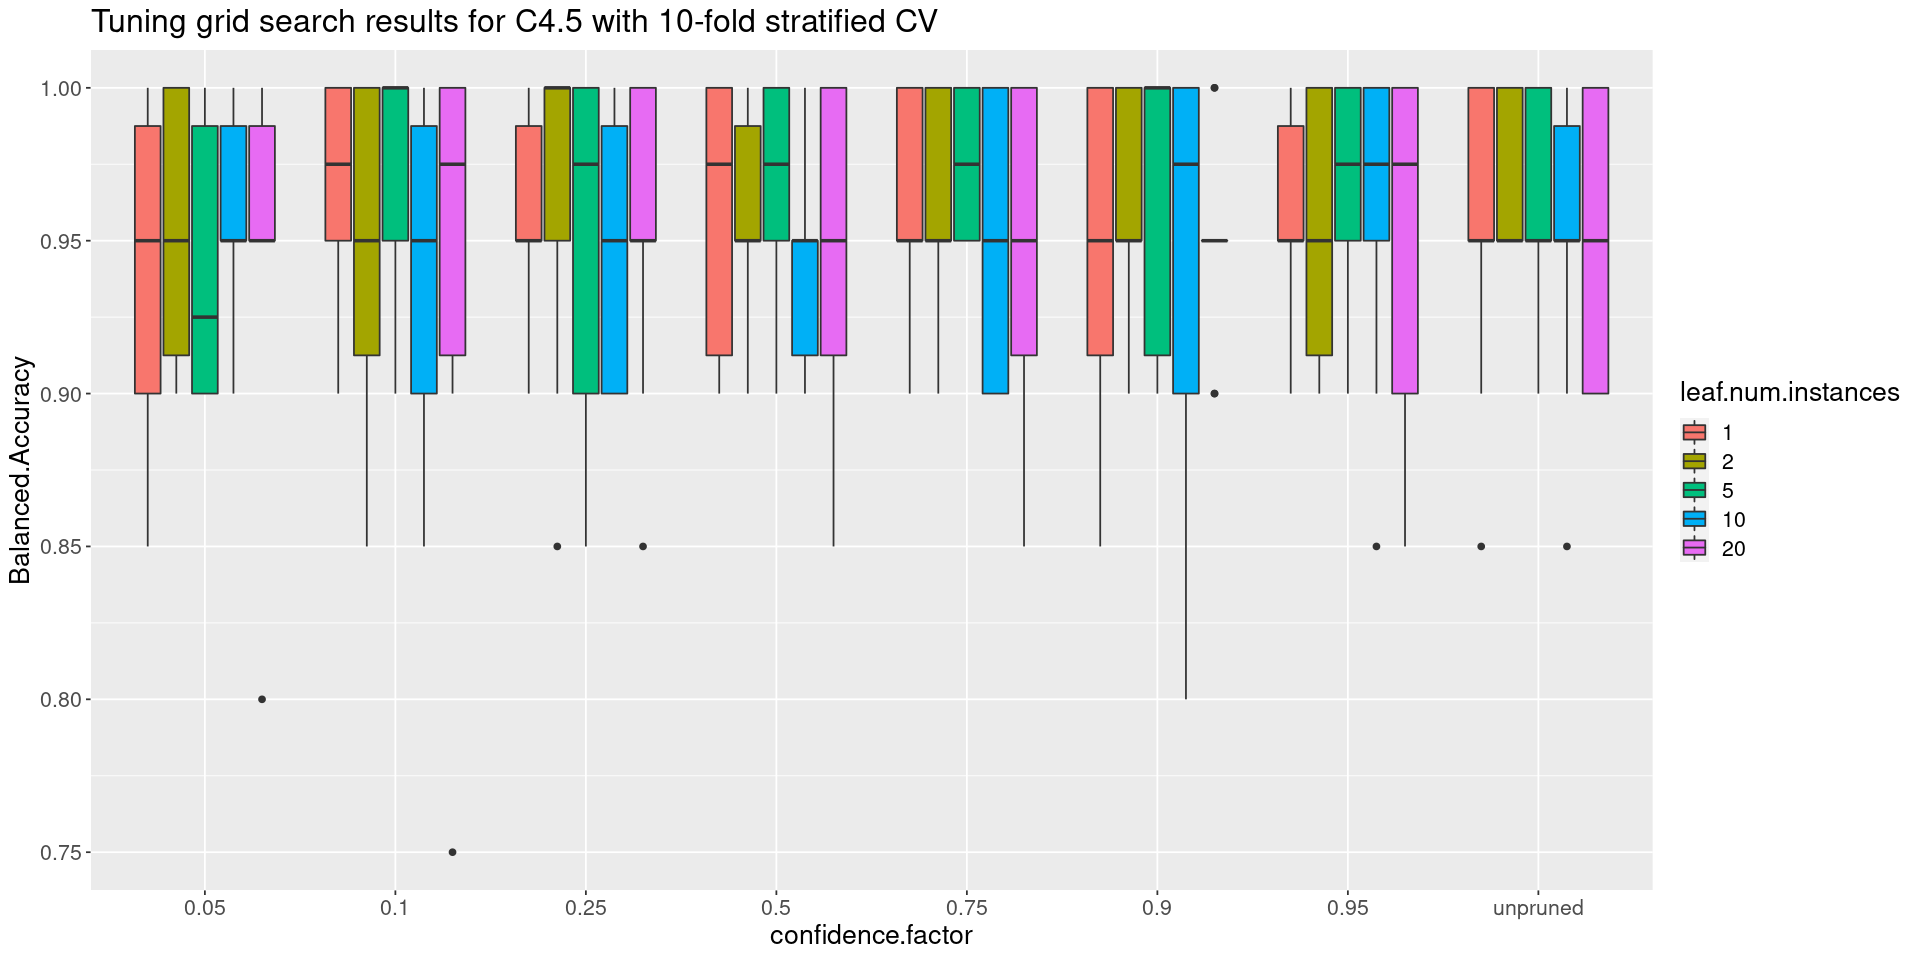

In [476]:
C45.tuned <- C45.tuning(
    seed=42, 
    data=irisData, 
    numFolds=10, 
    confidenceFactorList=c("unpruned", 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95),
    leafNumInstancesList=c(1, 2, 5, 10, 20),
    stratify=TRUE
)

C45.tuning.boxplot(C45.tuned)

Analizując wyniki dla różnych zestawów parametrów dla zbioru Iris nie zauważamy zbyt dużego wpływu ich doboru dla działania algorytmu. Mediana dla każdego z modeli jest w zakresie 0.95 - 1.0 (balanced accuracy). Najlepsze wyniki zdaje się osiągać drzewo z opcją `unpruned` (czyli nie przycinane), dla minimalnej ilości instancji na liść mniejszej od 20.

## 3. Analiza algorytmu C5.0

### 3.1 Uruchomienie dla domyślnych parametrów

In [485]:
trainRowNumbers <- createDataPartition(irisData$class, p = 0.7, list = FALSE)

trainData <- irisData[trainRowNumbers, ]
testData <- irisData[-trainRowNumbers, ]

In [486]:
fit.C50 <- C5.0(class~., data=trainData)
predictions <- predict(fit.C50, testData)

confusionMatrix(predictions, testData$class)

Confusion Matrix and Statistics

                 Reference
Prediction        Iris-setosa Iris-versicolor Iris-virginica
  Iris-setosa              15               0              0
  Iris-versicolor           0              13              1
  Iris-virginica            0               2             14

Overall Statistics
                                         
               Accuracy : 0.9333         
                 95% CI : (0.8173, 0.986)
    No Information Rate : 0.3333         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.9            
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: Iris-setosa Class: Iris-versicolor
Sensitivity                      1.0000                 0.8667
Specificity                      1.0000                 0.9667
Pos Pred Value                   1.0000                 0.9286
Neg Pred Value         

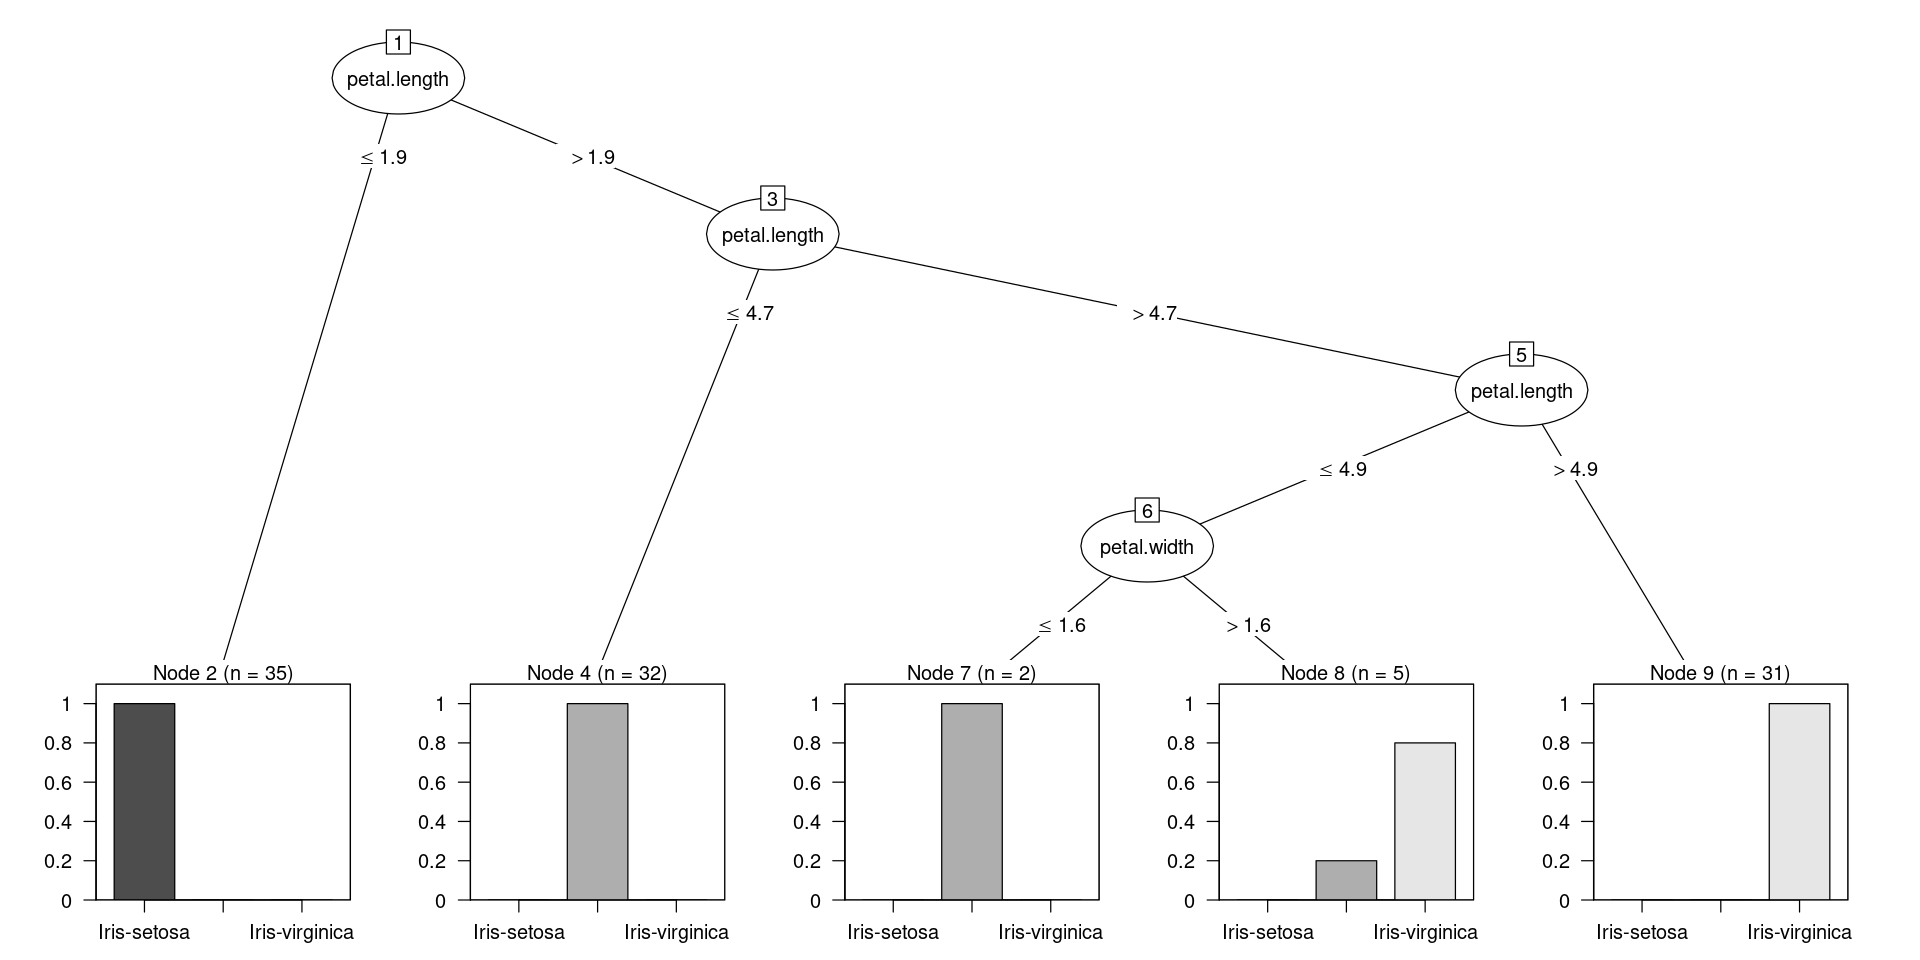

In [487]:
plot(fit.C50)

Drzewo C5.0 także w podejmowaniu decyzji opiera się tylko na cechach `petal`.

### 3.2 Strojenie parametrów

Algorytm C5.0 stroimy także przy użyciu dwóch wcześniej opisanych parametrów w kontekście C4.5: `confidence factor` i `minimum number of instances`. Poza tymi dwoma parametrami zbadamy także wpływ parametru logicznego `winnow`, który oznacza czy algorytm ma dokonać selekcji cech.

#### 3.2.1 Bez selekcji cech (winnow = FALSE)

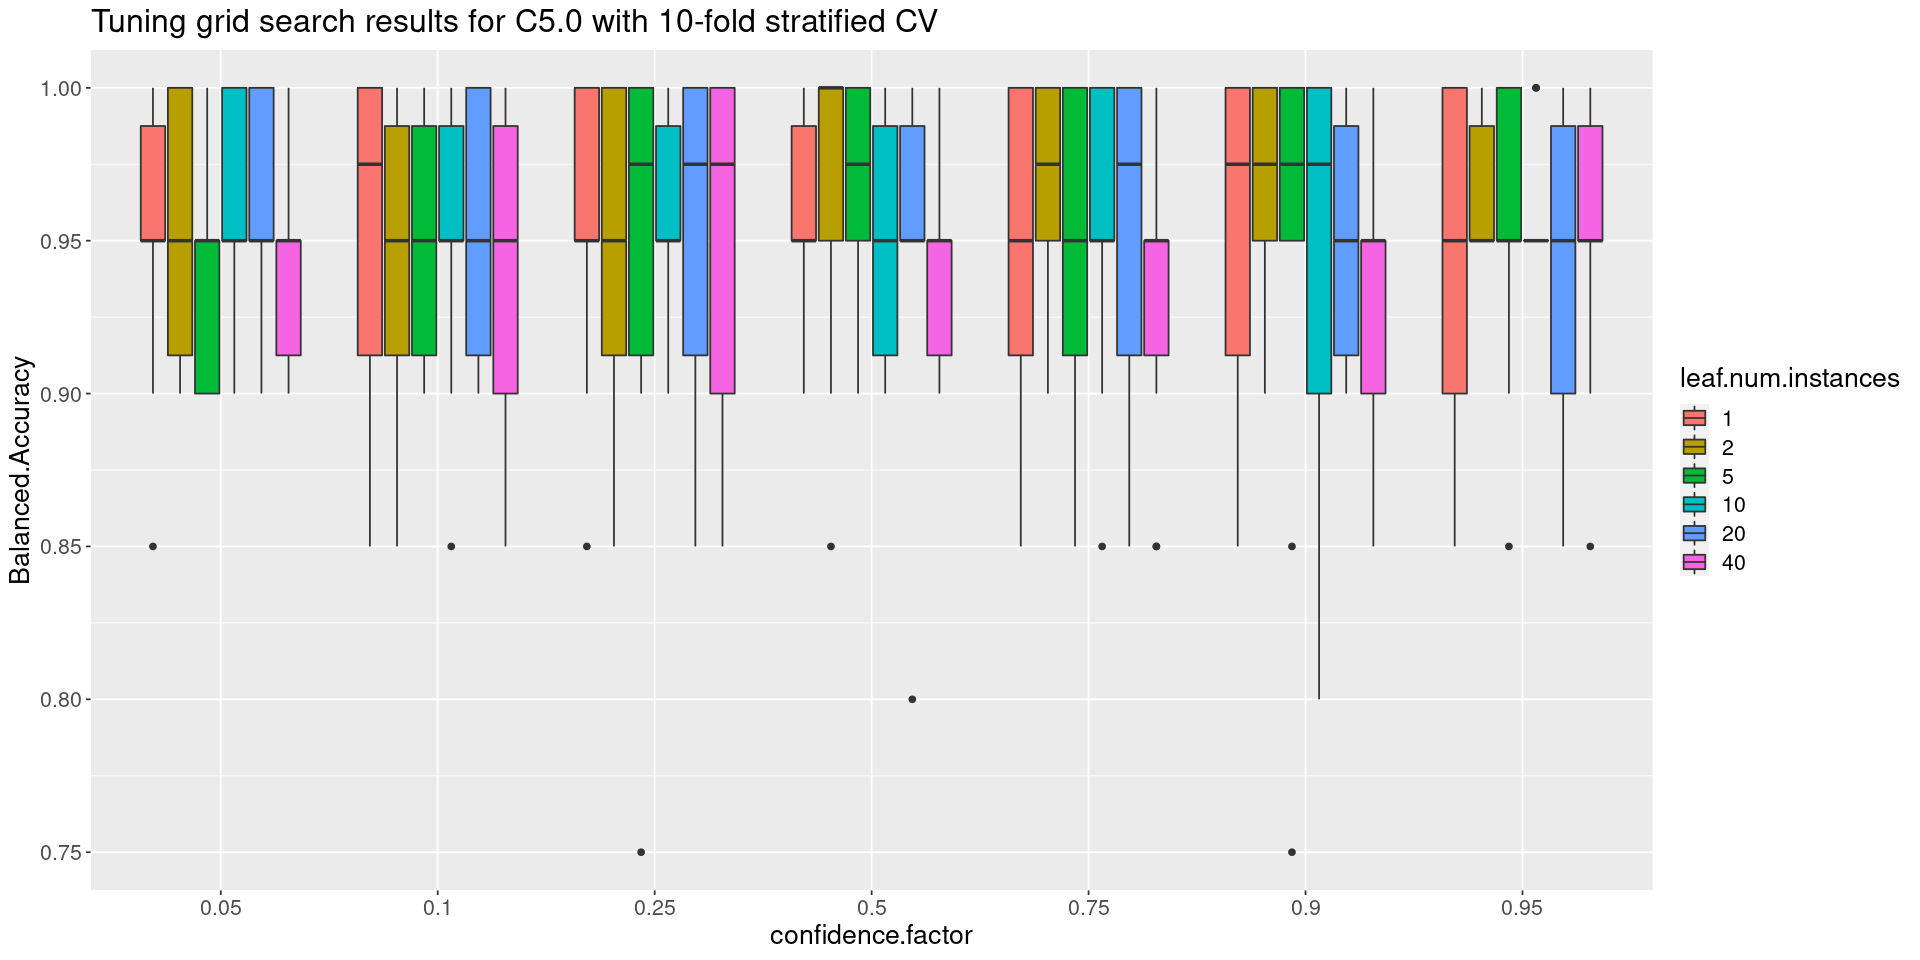

In [479]:
C50.tuned <- C50.tuning(
    seed=42, 
    data=irisData, 
    numFolds=10, 
    confidenceFactorList=c(0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95),
    leafNumInstancesList=c(1, 2, 5, 10, 20, 40),
    winnow=FALSE,
    stratify=TRUE
)

C50.tuning.boxplot(C50.tuned)

#### 3.2.2 Z selekcją cech (winnow = TRUE)

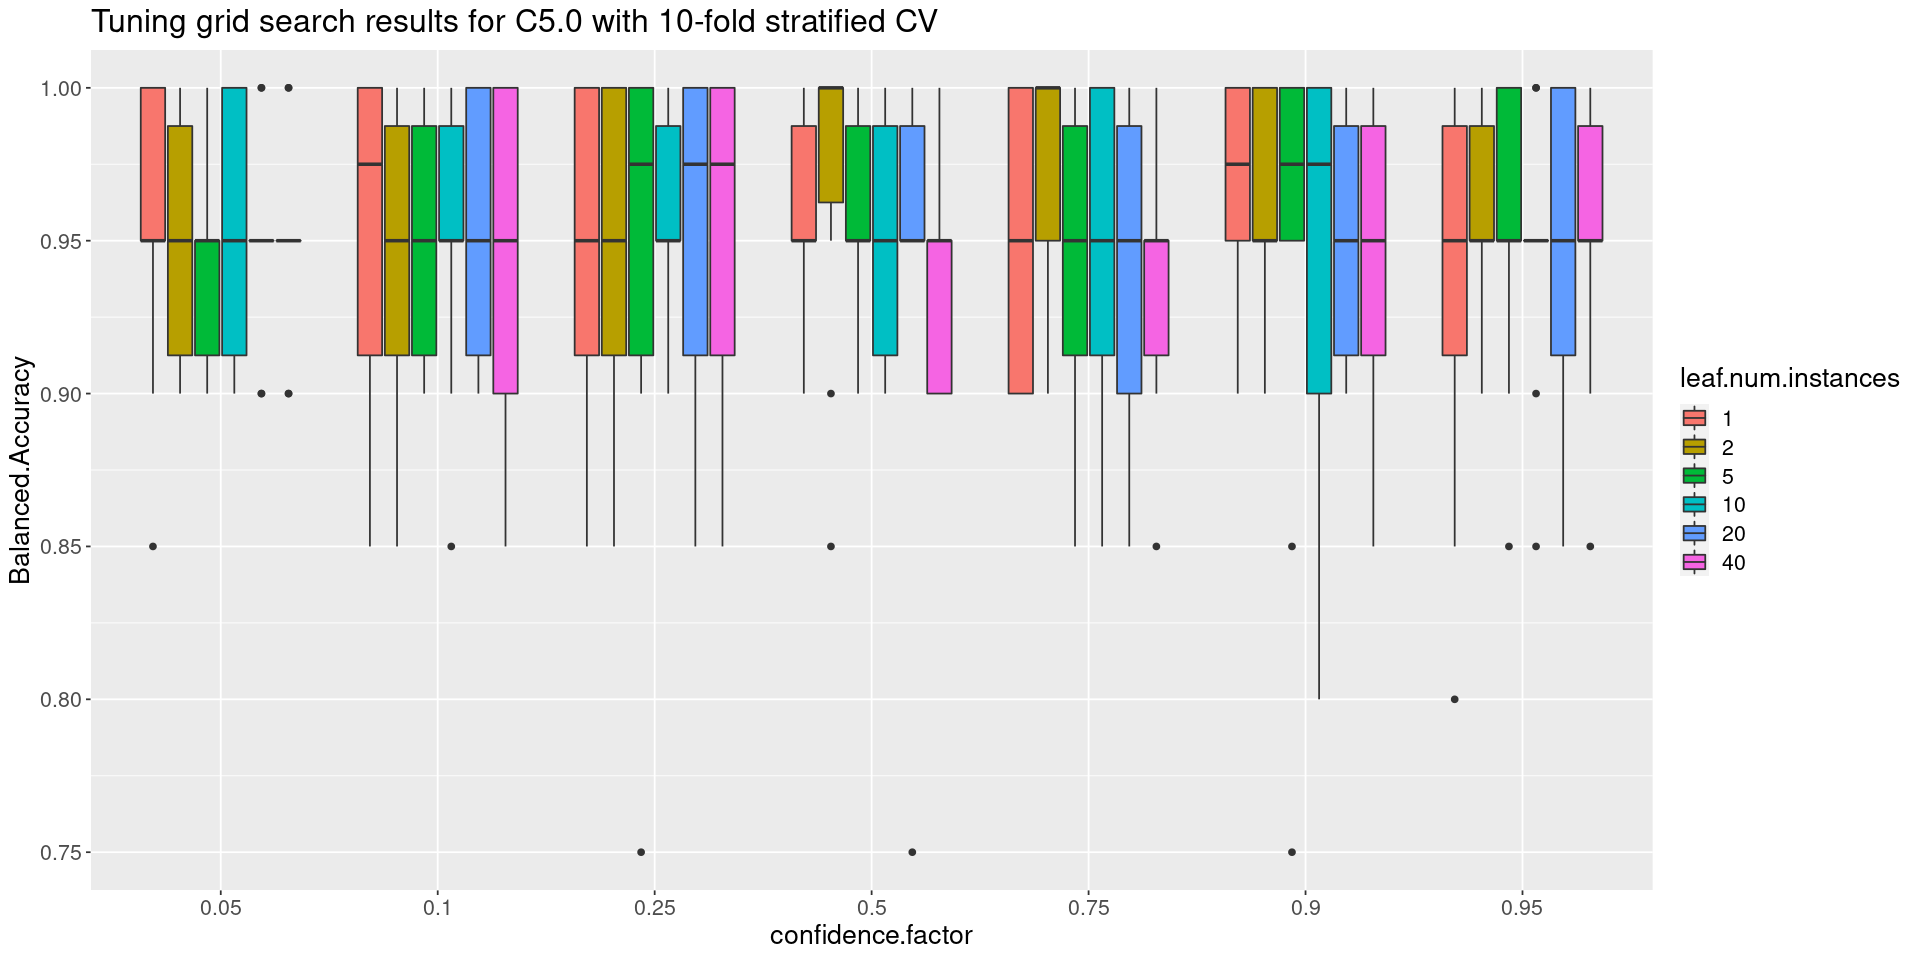

In [480]:
C50.tuned <- C50.tuning(
    seed=42, 
    data=irisData, 
    numFolds=10, 
    confidenceFactorList=c(0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95),
    leafNumInstancesList=c(1, 2, 5, 10, 20, 40),
    winnow=TRUE,
    stratify=TRUE
)

C50.tuning.boxplot(C50.tuned)

Podobnie jak dla C4.5, metoda C5.0 dla zbioru Iris także osiąga bardzo dobre rezultaty bez większego wpływu na jej działanie doboru parametrów. Najlepsze rezultaty zdają się być osiągane dla `confidence factor` = 0.5 i `minimum number of instances` mniejszego od 10. Nie dostrzegamy żadnego wpływu parametru `winnow`.

### 3.3 Porównanie C4.5 z C5.0 dla walidacji krzyżowej ze stratyfikacją i bez

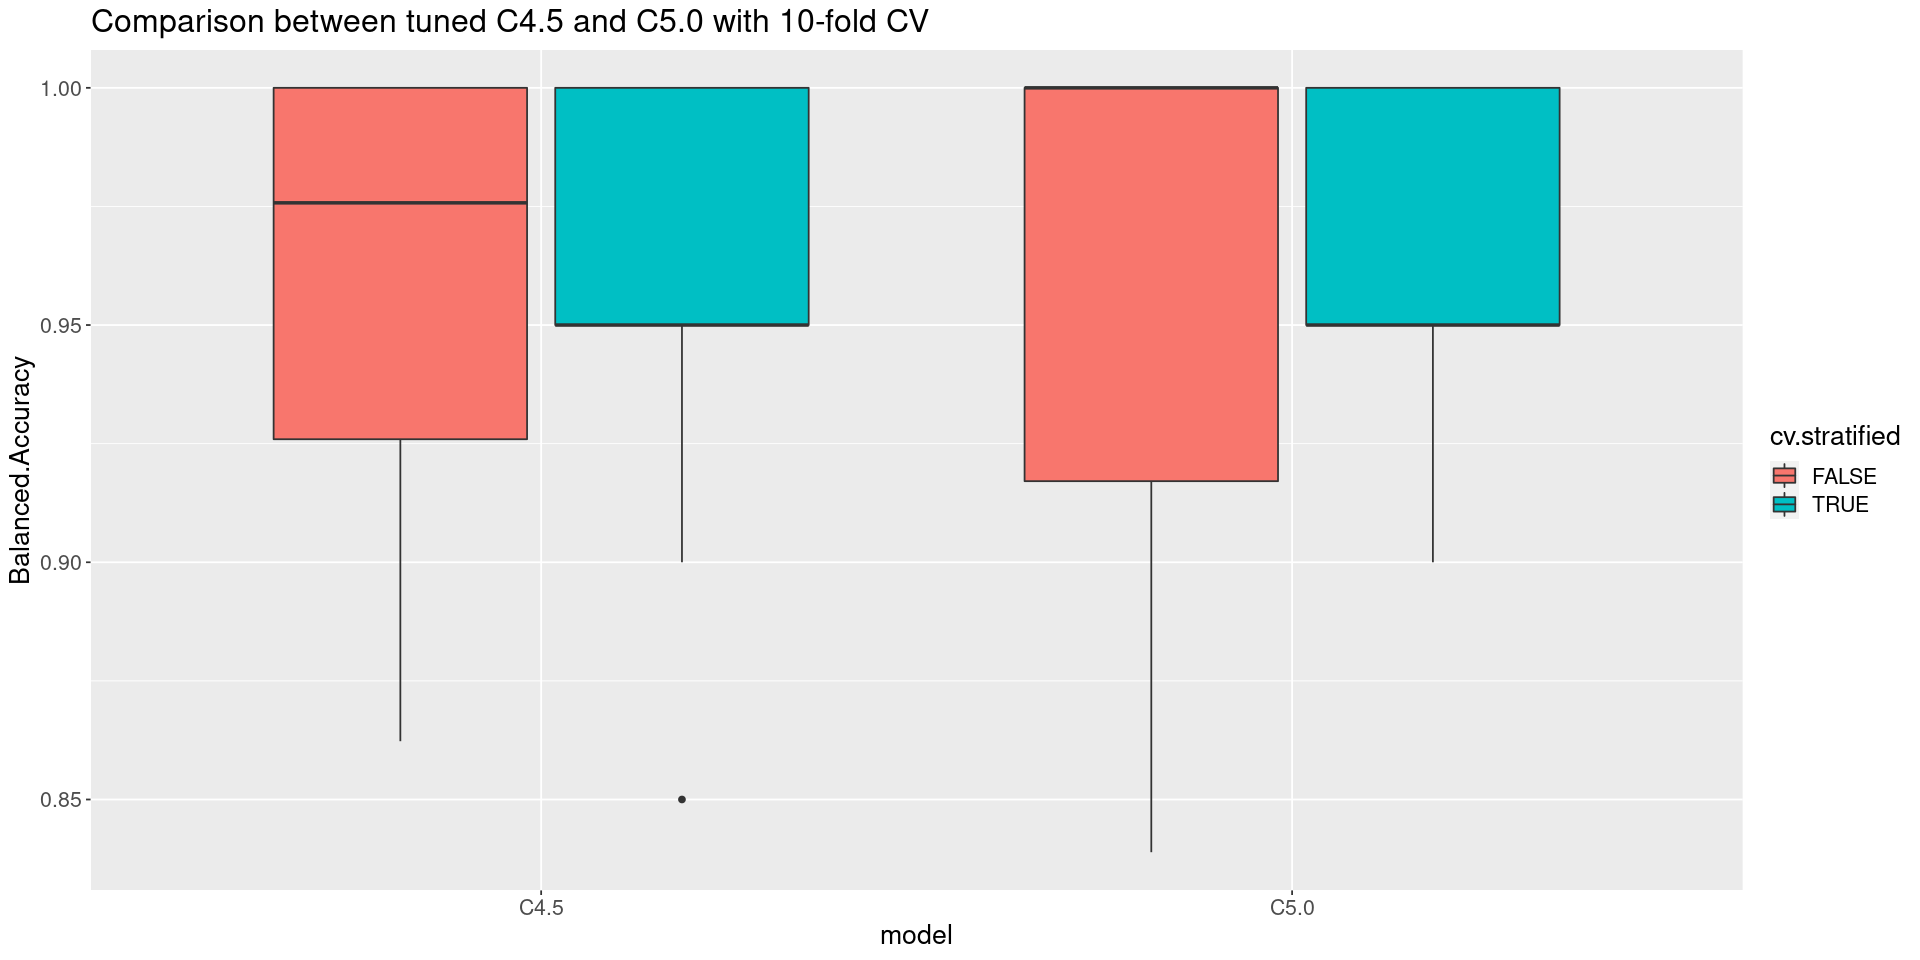

In [481]:
C45control <- Weka_control(M=2, U=TRUE)
C50control <- C5.0Control(CF=0.5, minCases=2, winnow=FALSE)

results <- decision.tree.comparison(42, irisData, C45control, C50control, 10)
decision.tree.comparison.boxplot(results)

Z dotunowanymi parametrami różnica pomiędzy C4.5 a C5.0 jest praktycznie niezauważalna - jedynie możemy dostrzec dla C4.5 jednego outliera lecz to może być kwestia statystycznie nie istotna. Zauważamy za to znaczącą różnicę pomiędzy zastosowaniem walidacji krzyżowej ze stratyfikacją i bez - pierwsza z tych opcji osiąga stabilnie lepsze rezultaty.

# WINE

## 1. Ładowanie zbioru danych

In [290]:
wineData <- read.csv("zbiory/wine.data", header = FALSE)
colnames(wineData) <- c(
    "class", "Alcohol", "Malic.acid", "Ash", "Alcanity.of.ash", "Magnesium", 
    "Total.phenols", "Flavanoids", "Nonflavanoid.phenosis", "Proanthocyanins",
    "Color.intensity", "Hue", "OD280/OD315.of.diluted wine", "Proline"
)

wineData$class=factor(wineData$class)
head(wineData)

,class,Alcohol,Malic.acid,Ash,Alcanity.of.ash,Magnesium,Total.phenols,Flavanoids,Nonflavanoid.phenosis,Proanthocyanins,Color.intensity,Hue,OD280/OD315.of.diluted wine,Proline
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
2,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
3,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
4,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
5,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
6,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


## 2. Analiza algorytmu C4.5

### 2.1 Uruchomienie dla domyślnych parametrów

In [490]:
trainRowNumbers <- createDataPartition(wineData$class, p = 0.7, list = FALSE)

trainData <- wineData[trainRowNumbers, ]
testData <- wineData[-trainRowNumbers, ]

In [491]:
fit.C45 <- J48(class~., data=trainData)
predictions <- predict(fit.C45, testData)

confusionMatrix(predictions, testData$class)

Confusion Matrix and Statistics

          Reference
Prediction  1  2  3
         1 17  1  0
         2  0 20  1
         3  0  0 13

Overall Statistics
                                          
               Accuracy : 0.9615          
                 95% CI : (0.8679, 0.9953)
    No Information Rate : 0.4038          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9414          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            1.0000   0.9524   0.9286
Specificity            0.9714   0.9677   1.0000
Pos Pred Value         0.9444   0.9524   1.0000
Neg Pred Value         1.0000   0.9677   0.9744
Prevalence             0.3269   0.4038   0.2692
Detection Rate         0.3269   0.3846   0.2500
Detection Prevalence   0.3462   0.4038   0.2500
Balanced Accuracy      0.9857   0.9601   0.9643

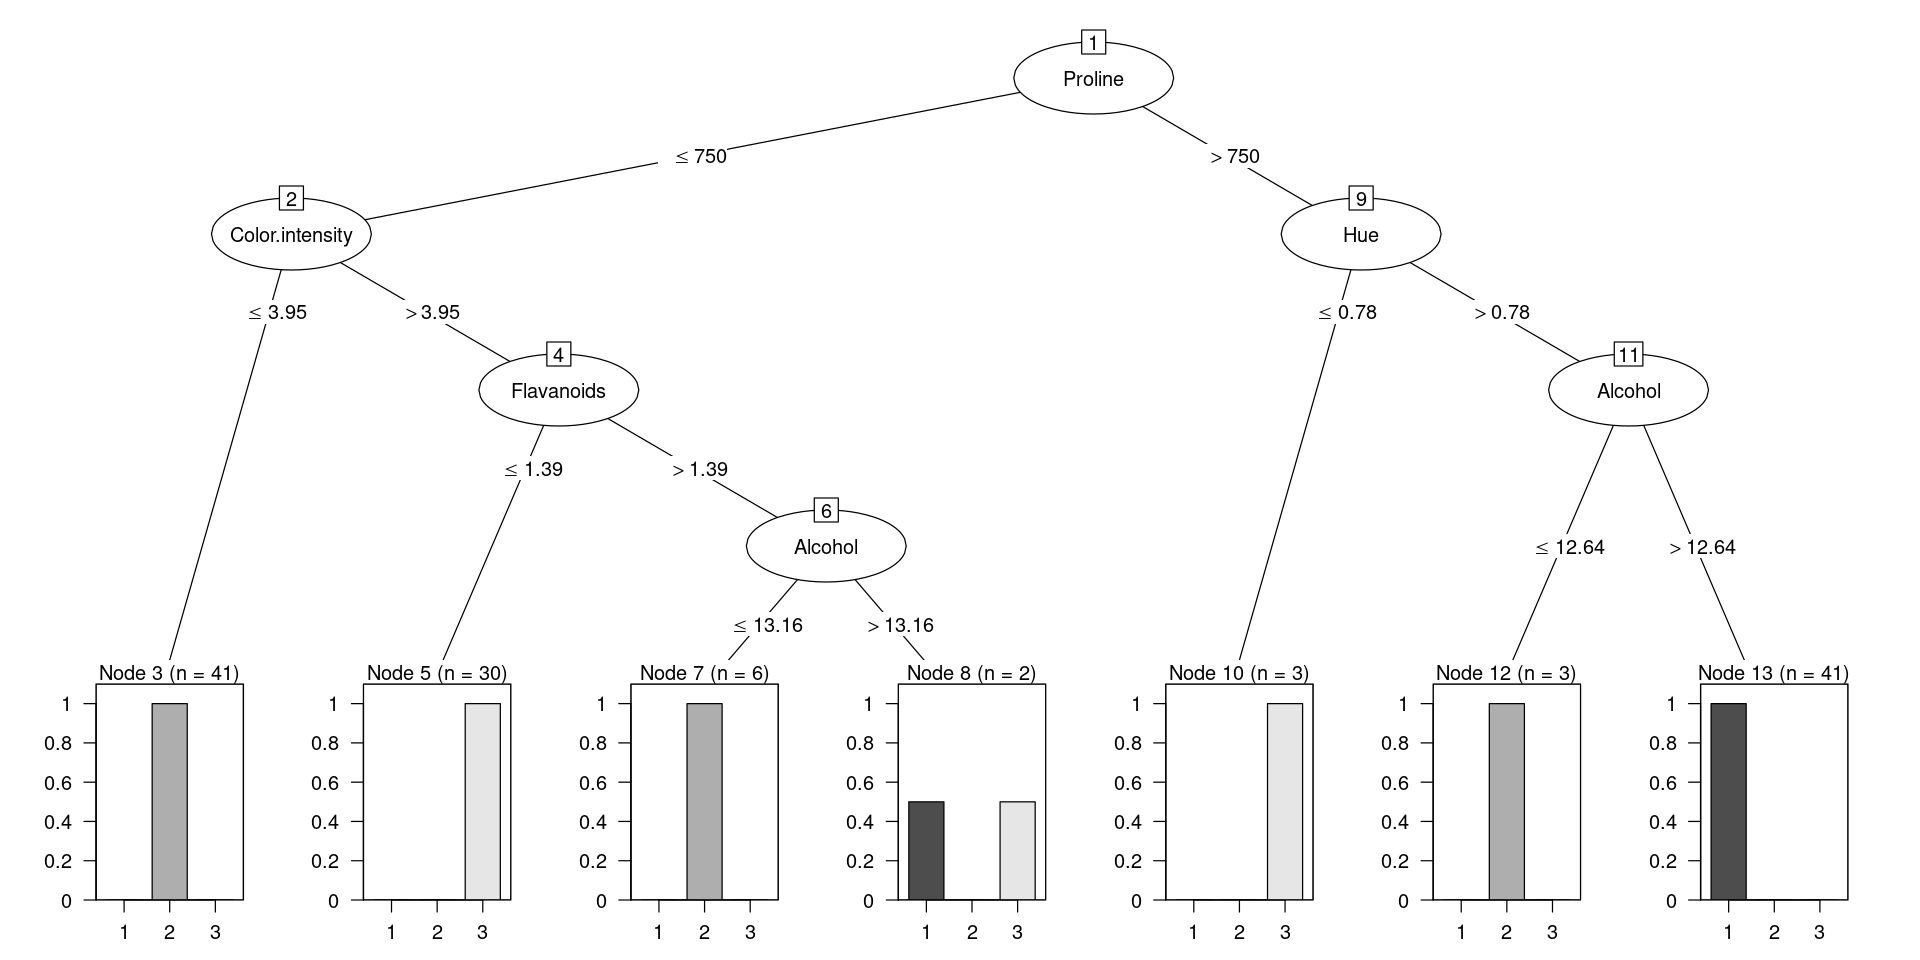

In [492]:
plot(fit.C45)

Podobnie jak dla zbioru Iris, widzimy, że i w tym przypadku drzewo decyzyjne nie bierze pod uwagę wszystkich cech - tylko połowę z nich. Ciekawy jest Node 8, w którym nie da się jednoznaczanie zdeterminować klasy - 1 i 3 mają takie same prawdopodobieństwo. Powodem, dla którego ów liść nie został rozdzielony w celu rozwiązania tego konfliktu, jest fakt, że do tego węzła doszły tylko 2 przypadki co jest za małą ilością aby podział się wydarzył.

### 2.2 Strojenie parametrów

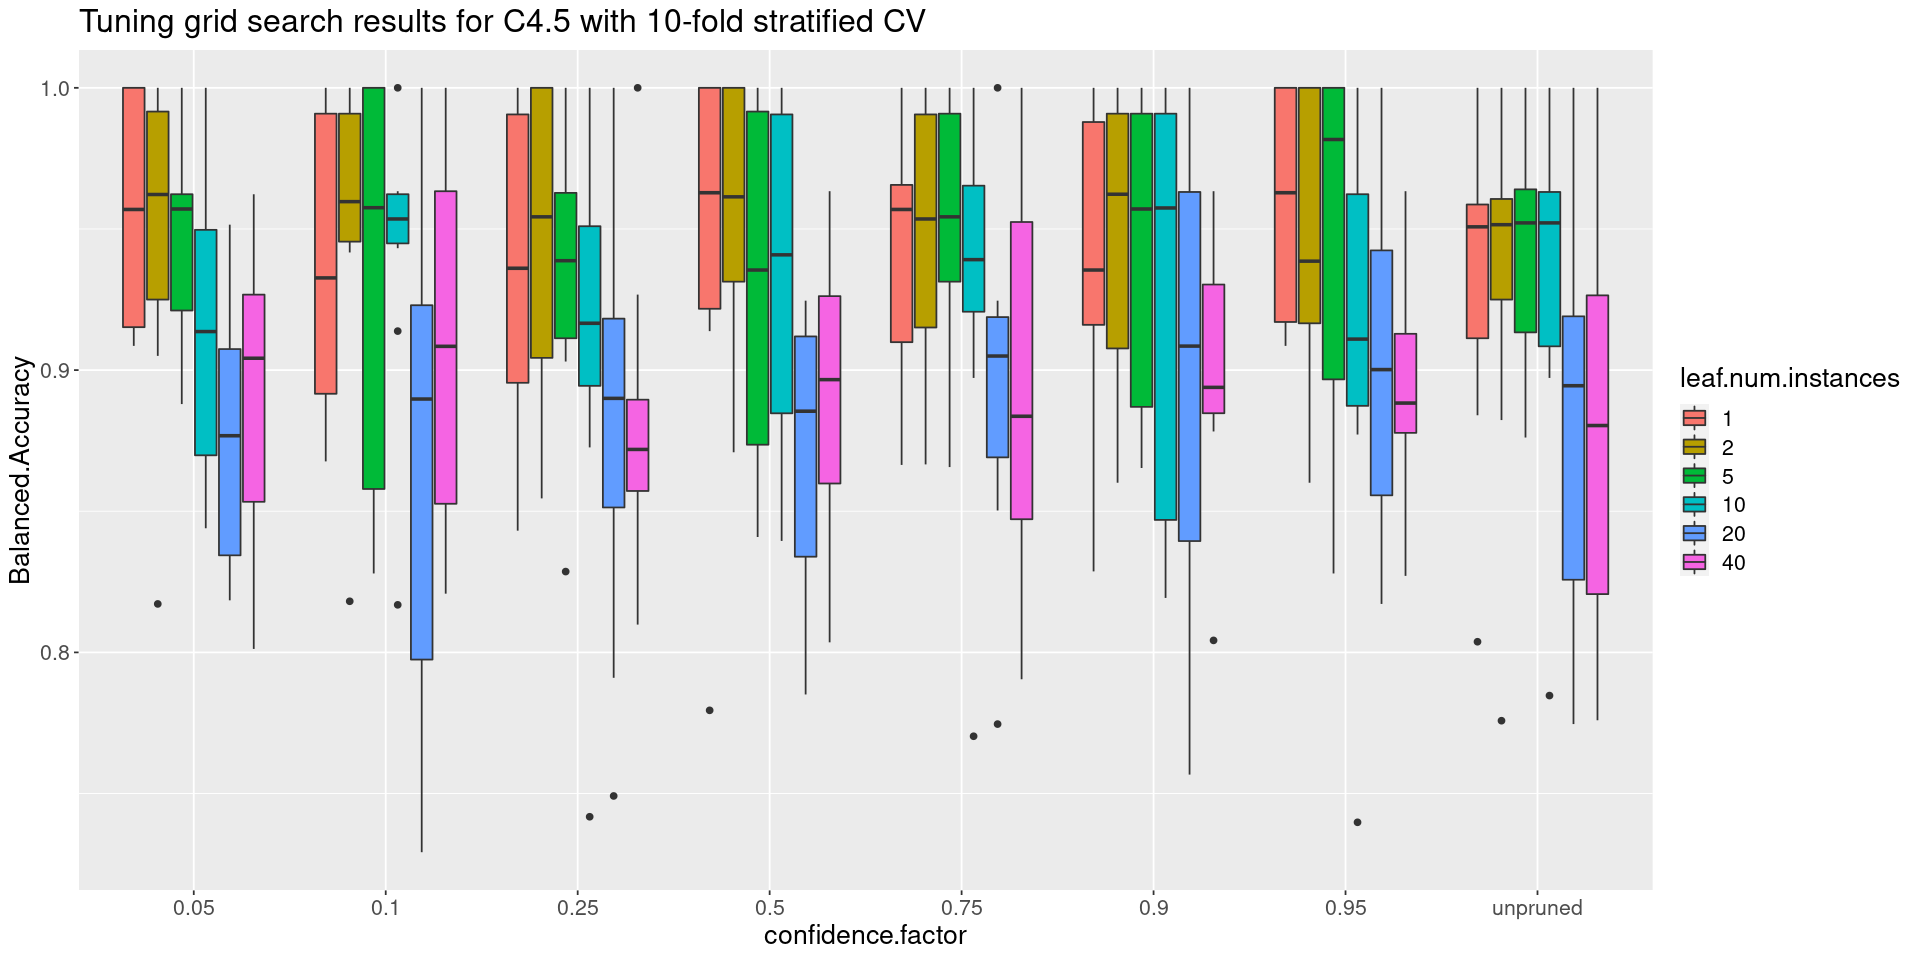

In [499]:
C45.tuned <- C45.tuning(
    seed=42, 
    data=wineData, 
    numFolds=10, 
    confidenceFactorList=c("unpruned", 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95),
    leafNumInstancesList=c(1, 2, 5, 10, 20, 40),
    stratify=TRUE
)

C45.tuning.boxplot(C45.tuned)

Analizując wyniki ewidentnie widzimy, że minimalna ilość instancji do podziału liścia równa 20 i 40 jest zbyt wysoka dla dowolnej wartości confidence. Widzimy także, że drzewo bez przycinania osiąga zdecydowanie gorsze wyniki od reszty. Najlepsze wyniki zdają się osiągać małe wartości minimalnej ilości instancji do podziału oraz wartości confidence < 0.5. 

## 3. Analiza algorytmu C5.0

### 3.1 Uruchomienie dla domyślnych parametrów

In [488]:
trainRowNumbers <- createDataPartition(wineData$class, p = 0.7, list = FALSE)

trainData <- wineData[trainRowNumbers, ]
testData <- wineData[-trainRowNumbers, ]

In [494]:
fit.C50 <- C5.0(class~., data=trainData)
predictions <- predict(fit.C50, testData)

confusionMatrix(predictions, testData$class)

Confusion Matrix and Statistics

          Reference
Prediction  1  2  3
         1 17  1  0
         2  0 20  1
         3  0  0 13

Overall Statistics
                                          
               Accuracy : 0.9615          
                 95% CI : (0.8679, 0.9953)
    No Information Rate : 0.4038          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9414          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            1.0000   0.9524   0.9286
Specificity            0.9714   0.9677   1.0000
Pos Pred Value         0.9444   0.9524   1.0000
Neg Pred Value         1.0000   0.9677   0.9744
Prevalence             0.3269   0.4038   0.2692
Detection Rate         0.3269   0.3846   0.2500
Detection Prevalence   0.3462   0.4038   0.2500
Balanced Accuracy      0.9857   0.9601   0.9643

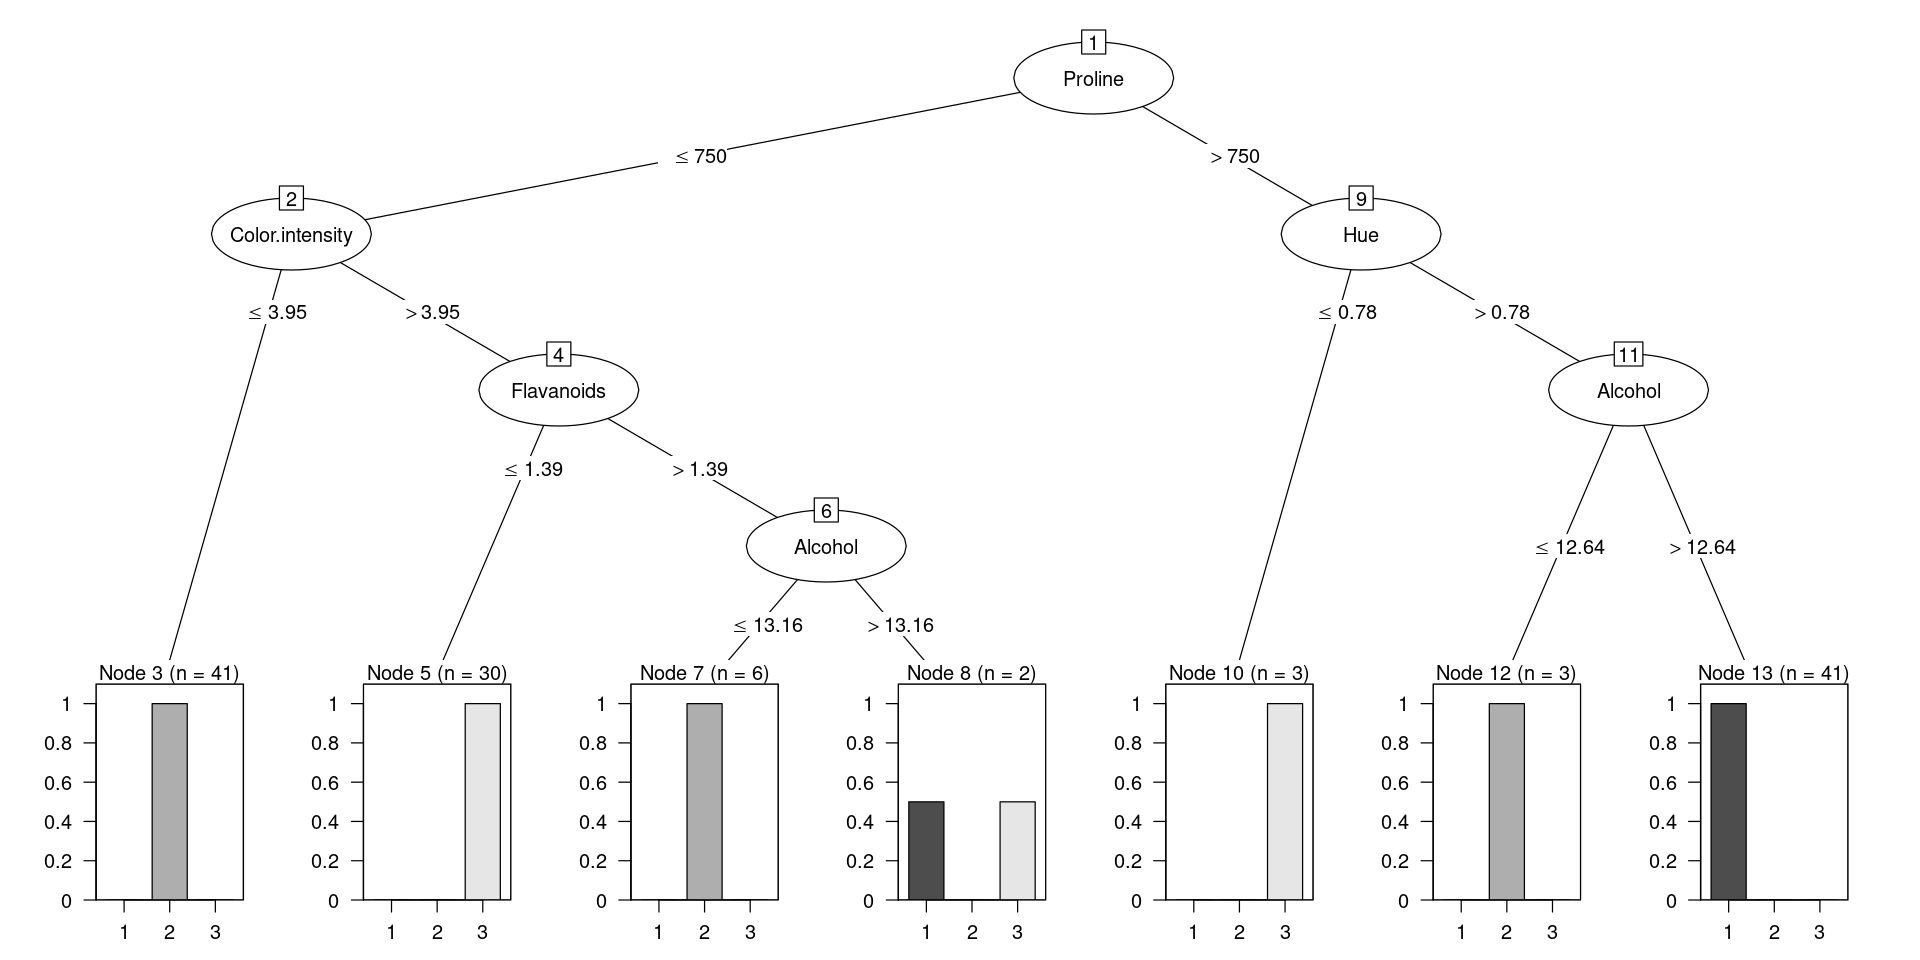

In [495]:
plot(fit.C50)

Drzewo wytworzone przez metodę C50 jest identyczne z tym dla C45.

### 3.2 Strojenie parametrów

#### 3.2.1 Bez selekcji cech (winnow = FALSE)

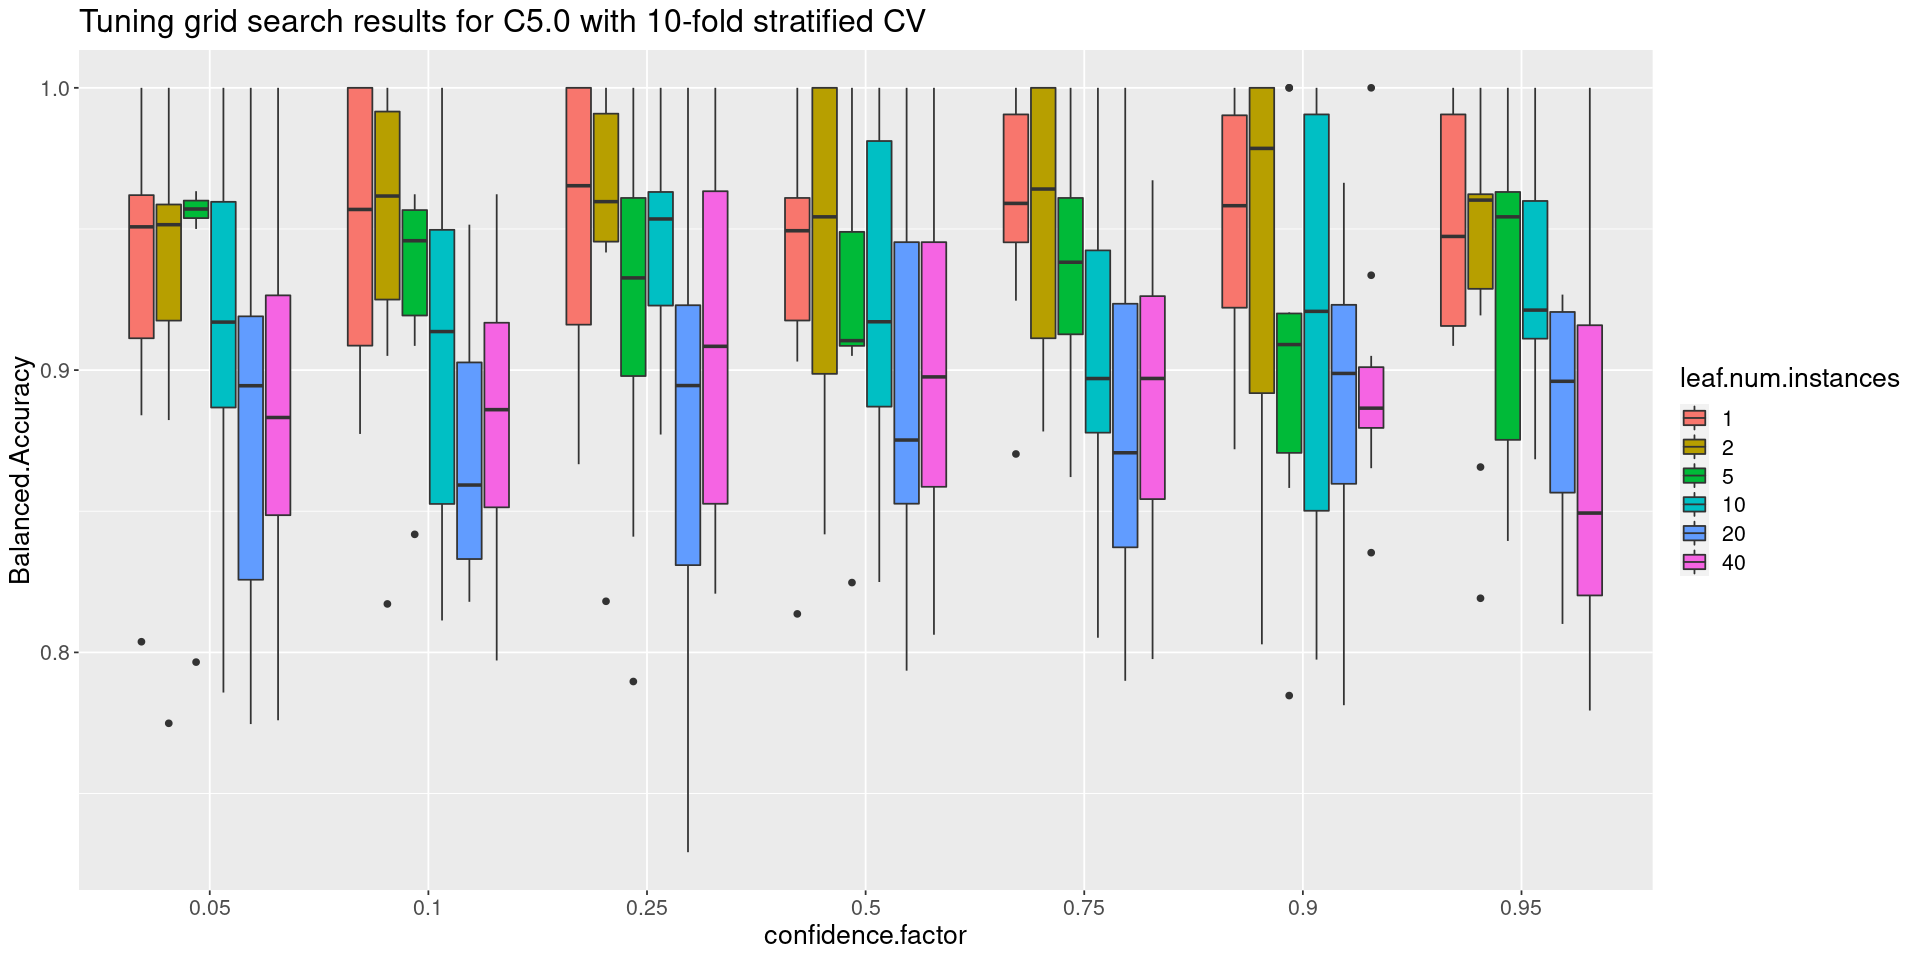

In [500]:
C50.tuned <- C50.tuning(
    seed=42, 
    data=wineData, 
    numFolds=10, 
    confidenceFactorList=c(0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95),
    leafNumInstancesList=c(1, 2, 5, 10, 20, 40),
    winnow=FALSE,
    stratify=TRUE
)

C50.tuning.boxplot(C50.tuned)

#### 3.2.1 Z selekcją cech (winnow = TRUE)

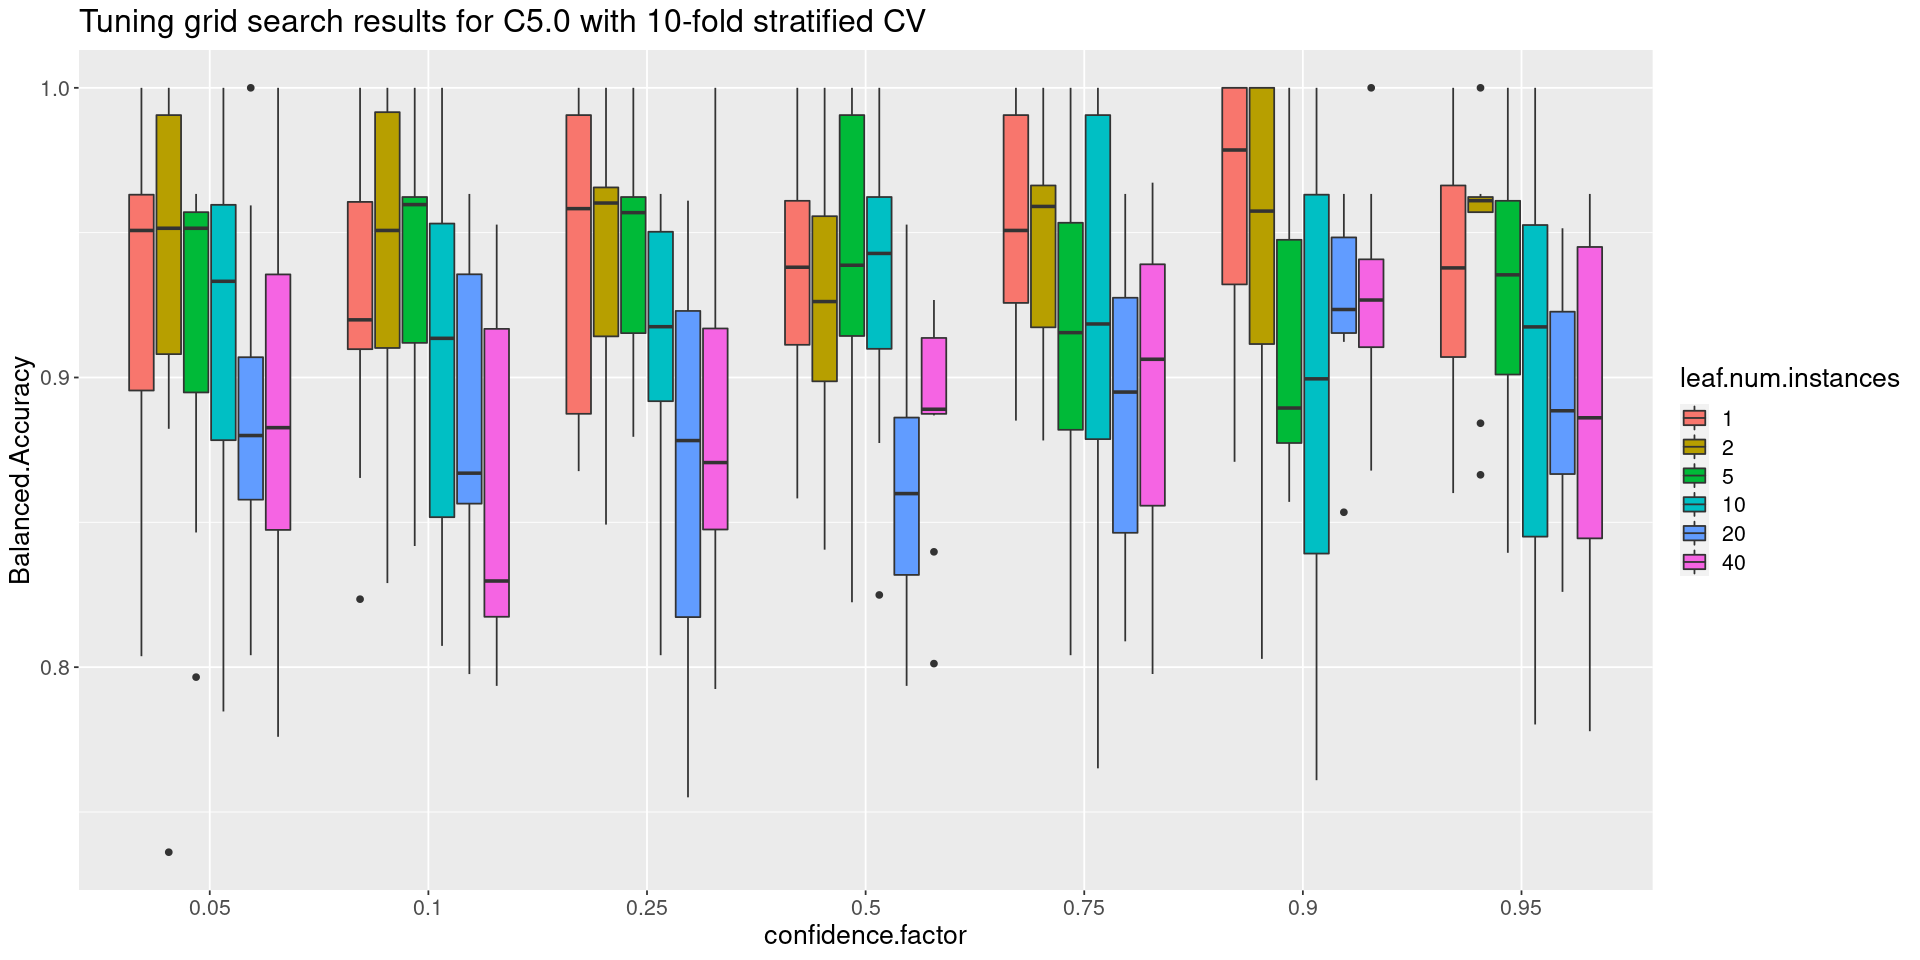

In [501]:
C50.tuned <- C50.tuning(
    seed=42, 
    data=wineData, 
    numFolds=10, 
    confidenceFactorList=c(0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95),
    leafNumInstancesList=c(1, 2, 5, 10, 20, 40),
    winnow=TRUE,
    stratify=TRUE
)

C50.tuning.boxplot(C50.tuned)

Tak jak dla C45 widzimy, że wysokie wartości liczby instancji wymaganej do podziału liścia zachowują się dużo gorzej. Różnica pomiędzy parametrem `winnow` a jego brakiem nie jest zbyt zauważalna. Najlepsze wyniki osiągają drzewa z liczbą instancji wymaganej do podziału liścia równą 0 lub 1.

### 3.3 Porównanie C4.5 z C5.0 dla walidacji krzyżowej ze stratyfikacją i bez

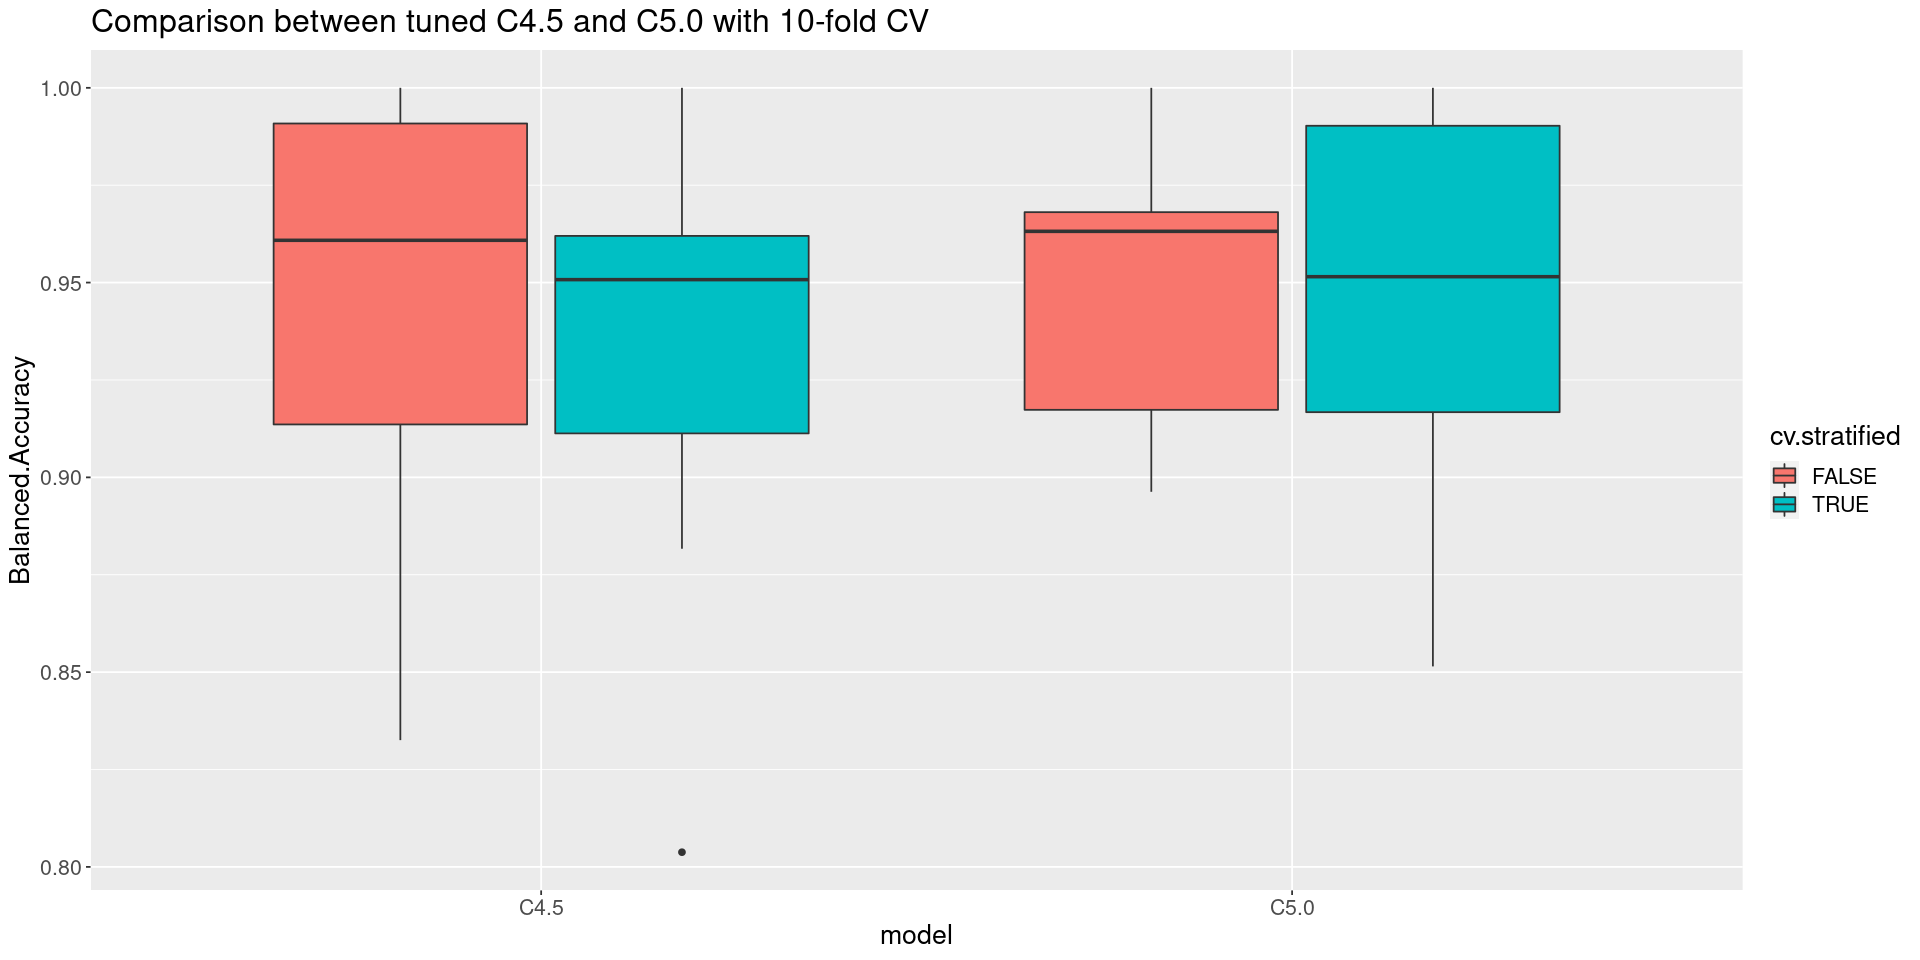

In [502]:
C45control <- Weka_control(M=2, C=0.5)
C50control <- C5.0Control(CF=0.75, minCases=1, winnow=FALSE)

results <- decision.tree.comparison(42, wineData, C45control, C50control, 10)
decision.tree.comparison.boxplot(results)

Drzewa C45 i C50 osiągają dosyć mocno zbliżone wyniki. Nie widzimy też zbytniej różnicy pomiędzy zastosowaniem walidacji krzyżowej stratyfikowanej a zwykłej. Pamiętając z poprzendich list, zbiór WINE miał dosyć dobry balans klas zatem taki wynik może być dziełem losowości. Wszystkie modele osiągają dobry wynik na poziomie 0.95 balanced accuracy.

# GLASS

## 1. Ładowanie zbioru danych

In [310]:
glassData <- read.csv("zbiory/glass.data")
colnames(glassData) <- c("index", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "class")
glassData <- subset(glassData, select = -c(index))

glassData$class=factor(glassData$class)
head(glassData)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0,0.00,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0,0.00,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0,0.00,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0,0.00,1
5,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0,0.26,1
6,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0,0.00,1


## 2. Analiza algorytmu C4.5

### 2.1 Uruchomienie dla domyślnych parametrów

In [535]:
trainRowNumbers <- createDataPartition(glassData$class, p = 0.7, list = FALSE)

trainData <- glassData[trainRowNumbers, ]
testData <- glassData[-trainRowNumbers, ]

In [536]:
fit.C45 <- J48(class~., data=trainData)
predictions <- predict(fit.C45, testData)

confusionMatrix(predictions, testData$class)

Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  5  6  7
         1 13  2  1  0  0  1
         2  5 17  4  0  1  0
         3  1  2  0  0  1  0
         5  0  1  0  3  0  0
         6  0  0  0  0  0  0
         7  1  0  0  0  0  7

Overall Statistics
                                          
               Accuracy : 0.6667          
                 95% CI : (0.5331, 0.7831)
    No Information Rate : 0.3667          
    P-Value [Acc > NIR] : 2.32e-06        
                                          
                  Kappa : 0.5331          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 5 Class: 6 Class: 7
Sensitivity            0.6500   0.7727  0.00000  1.00000  0.00000   0.8750
Specificity            0.9000   0.7368  0.92727  0.98246  1.00000   0.9808
Pos Pred Value         0.7647   0.6296  0.00000  0.75000      NaN   0.8750
Neg Pred Value

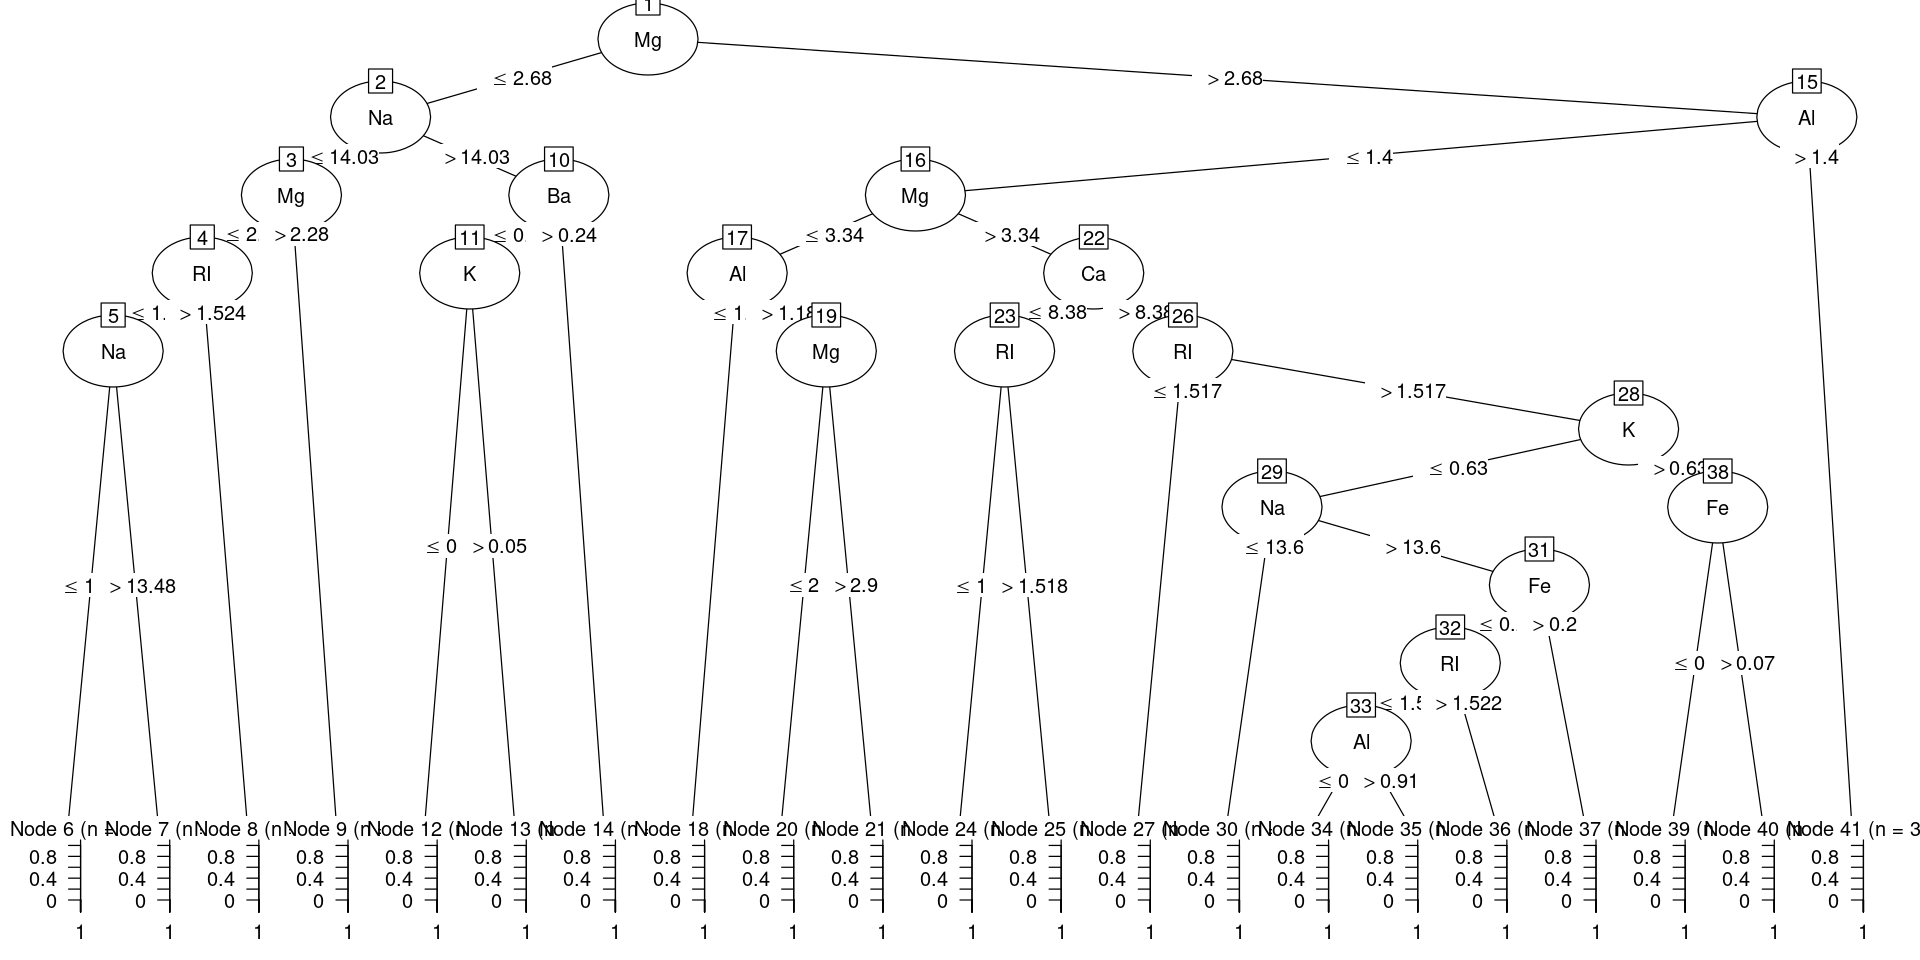

In [516]:
plot(fit.C45)

Drzewo dla zbioru GLASS jest zdecydowanie bardziej złożone w porównaniu do poprzednich drzew. Niewątpliwie wpływ na taki efekt ma większa ilość klas w zbiorze - 6.

## 2.2 Strojenie parametrów

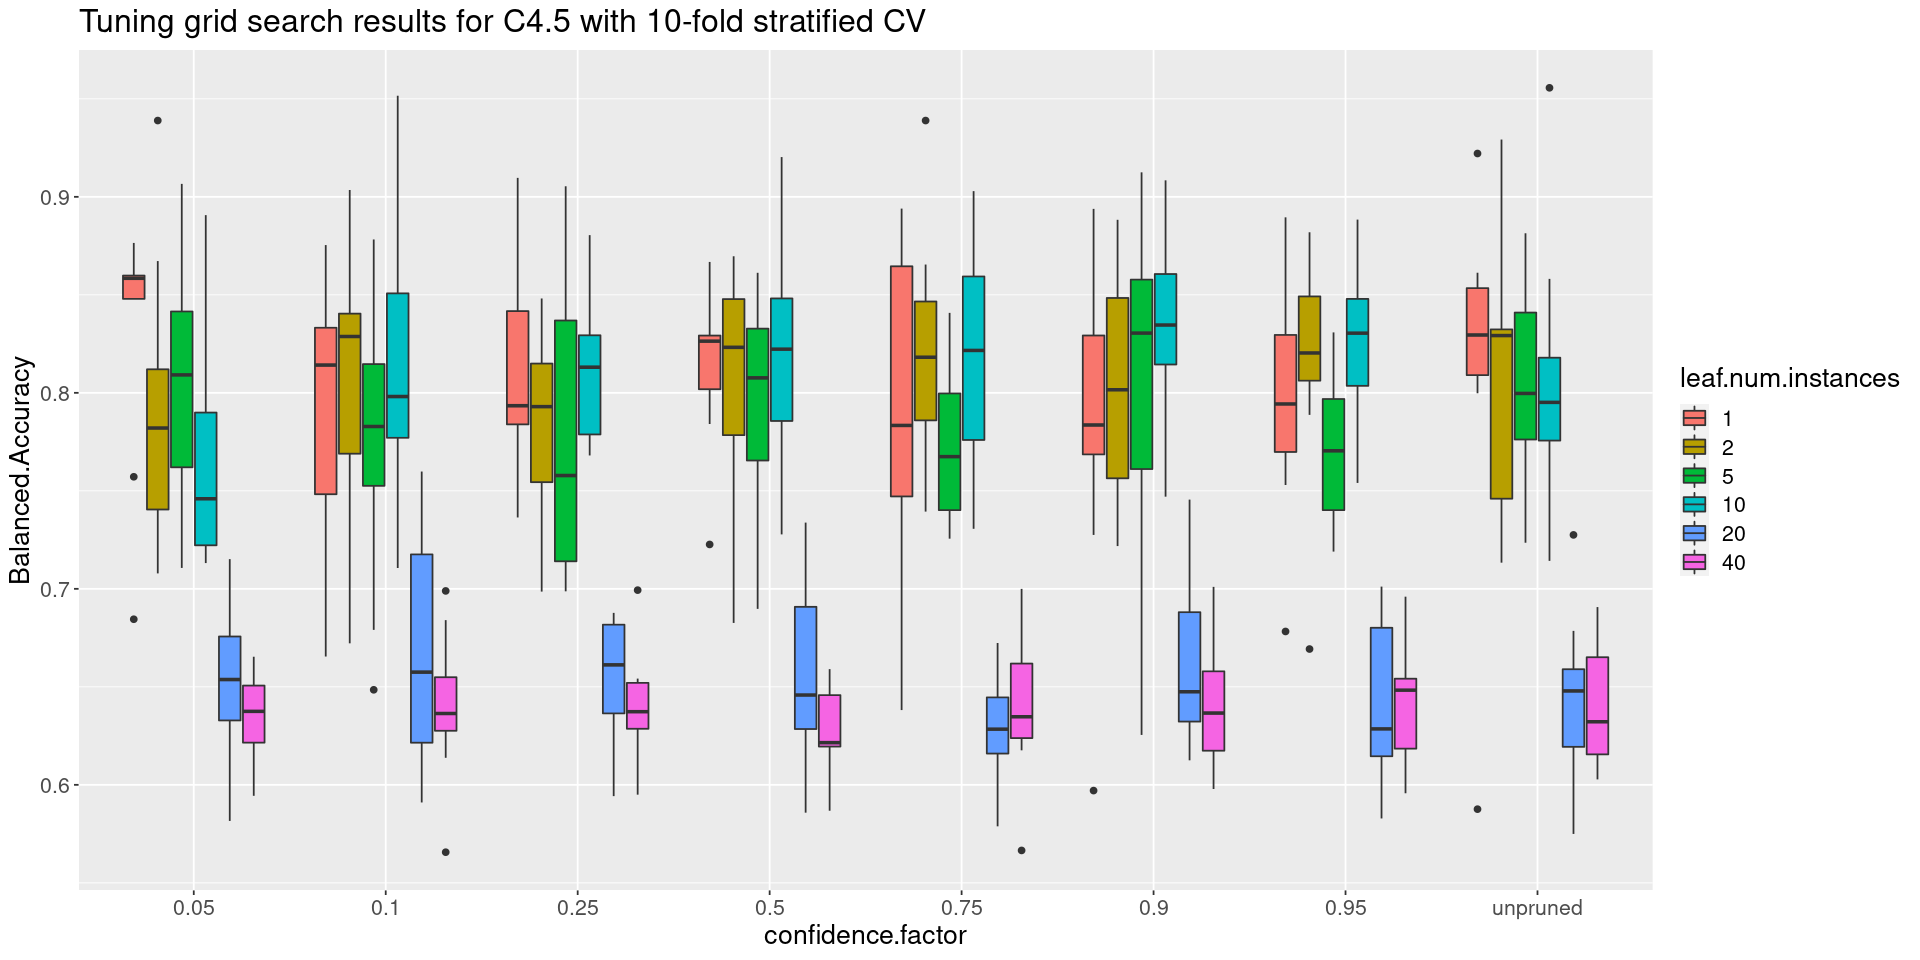

In [517]:
C45.tuned <- C45.tuning(
    seed=42, 
    data=glassData, 
    numFolds=9, 
    confidenceFactorList=c("unpruned", 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95),
    leafNumInstancesList=c(1, 2, 5, 10, 20, 40),
    stratify=TRUE
)

C45.tuning.boxplot(C45.tuned)

Tak jak i dla poprzednich zbiorów, widzimy, że wartości 20 i 40 dla minimalnej liczby instancji wymaganej do podziału liścia, są zbyt wysokie - te modele znacząco odstają od pozostałych. Dla pozoztałych zestawów parametrów nie zauważamy żadnego istotnego trendu, który by wskazywał, że jeden zestaw parametrów jest lepszy dla pozostałych. Nawet drzewo bez przycinania tym razem osiąga porónywalnie dobre rezultaty.

## 3. Analiza algorytmu C5.0

### 3.1 Uruchomienie dla domyślnych parametrów

In [537]:
trainRowNumbers <- createDataPartition(glassData$class, p = 0.7, list = FALSE)

trainData <- glassData[trainRowNumbers, ]
testData <- glassData[-trainRowNumbers, ]

In [538]:
fit.C50 <- C5.0(class~., data=trainData)
predictions <- predict(fit.C50, testData)

confusionMatrix(predictions, testData$class)

Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  5  6  7
         1 12  0  0  0  0  0
         2  2 16  1  0  0  1
         3  4  0  3  0  0  0
         5  0  0  0  2  0  0
         6  0  3  0  0  2  0
         7  2  3  1  1  0  7

Overall Statistics
                                          
               Accuracy : 0.7             
                 95% CI : (0.5679, 0.8115)
    No Information Rate : 0.3667          
    P-Value [Acc > NIR] : 1.63e-07        
                                          
                  Kappa : 0.6083          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 5 Class: 6 Class: 7
Sensitivity            0.6000   0.7273  0.60000  0.66667  1.00000   0.8750
Specificity            1.0000   0.8947  0.92727  1.00000  0.94828   0.8654
Pos Pred Value         1.0000   0.8000  0.42857  1.00000  0.40000   0.5000
Neg Pred Value

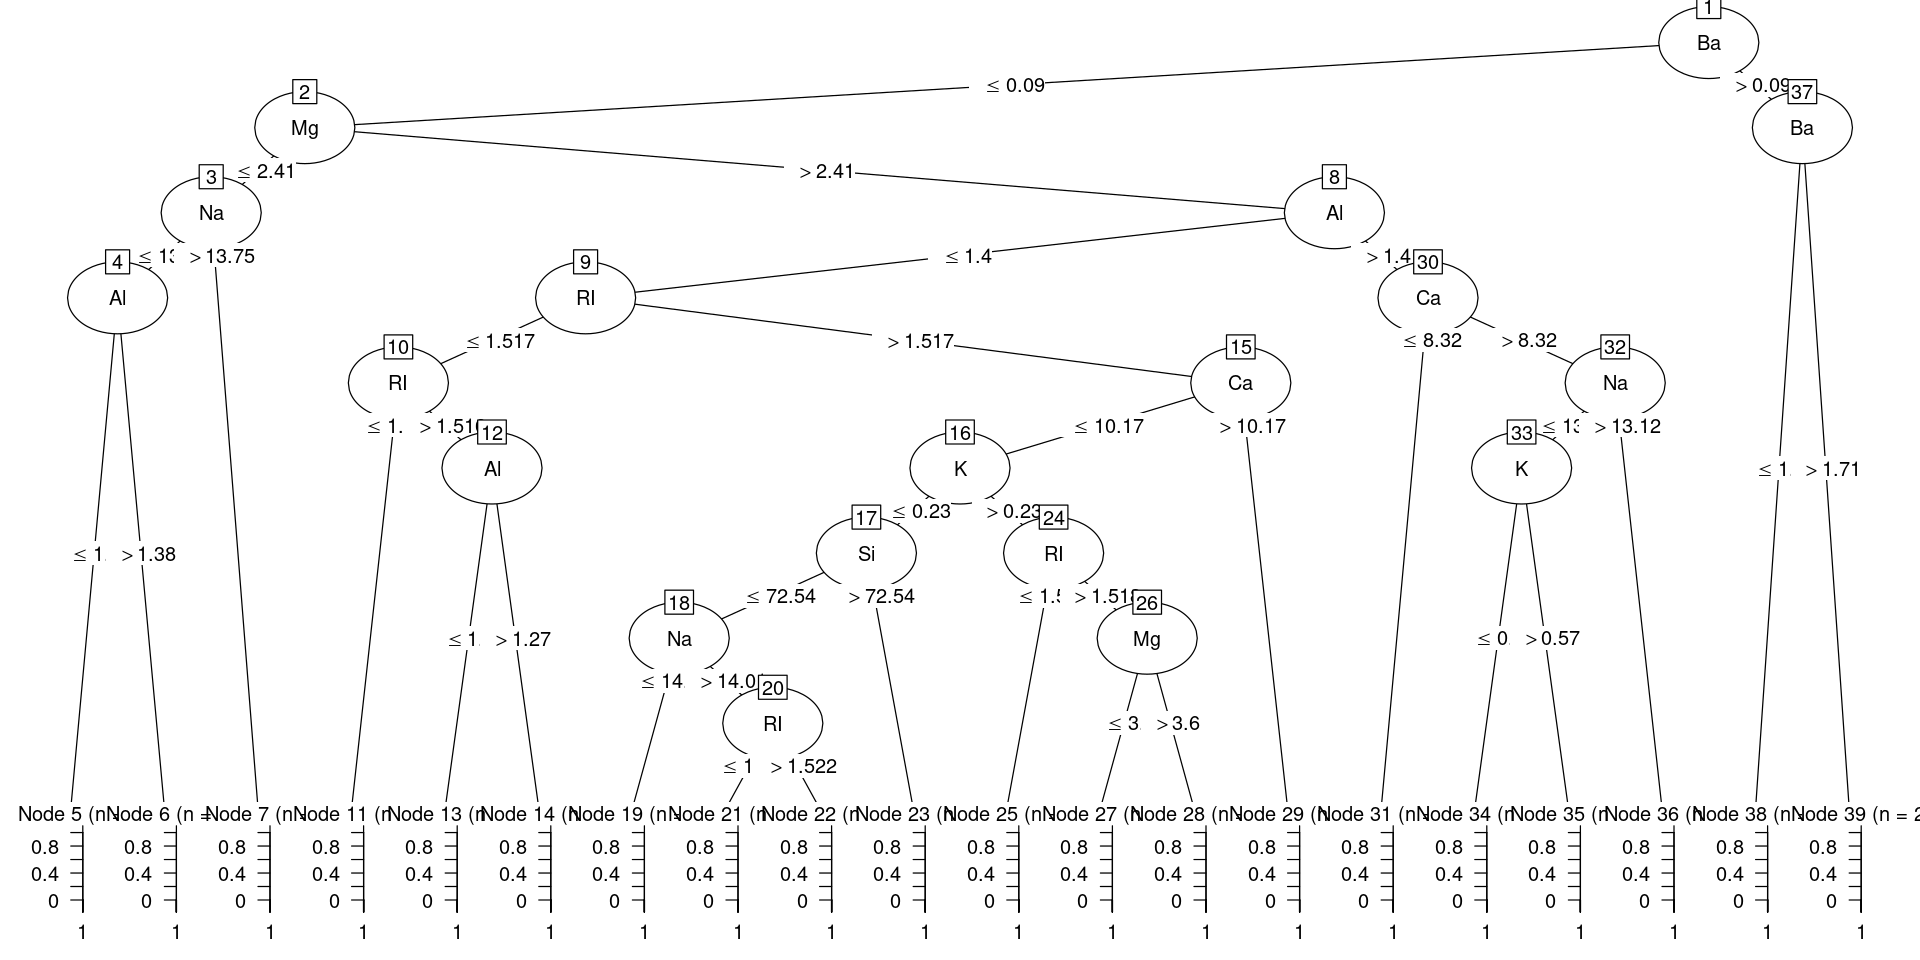

In [539]:
plot(fit.C50)

Drzewo C50 jest równie skomplikowanie złożone jak C45.

### 3.2 Strojenie parametrów

#### 3.2.1 Bez selekcji cech (winnow = FALSE)

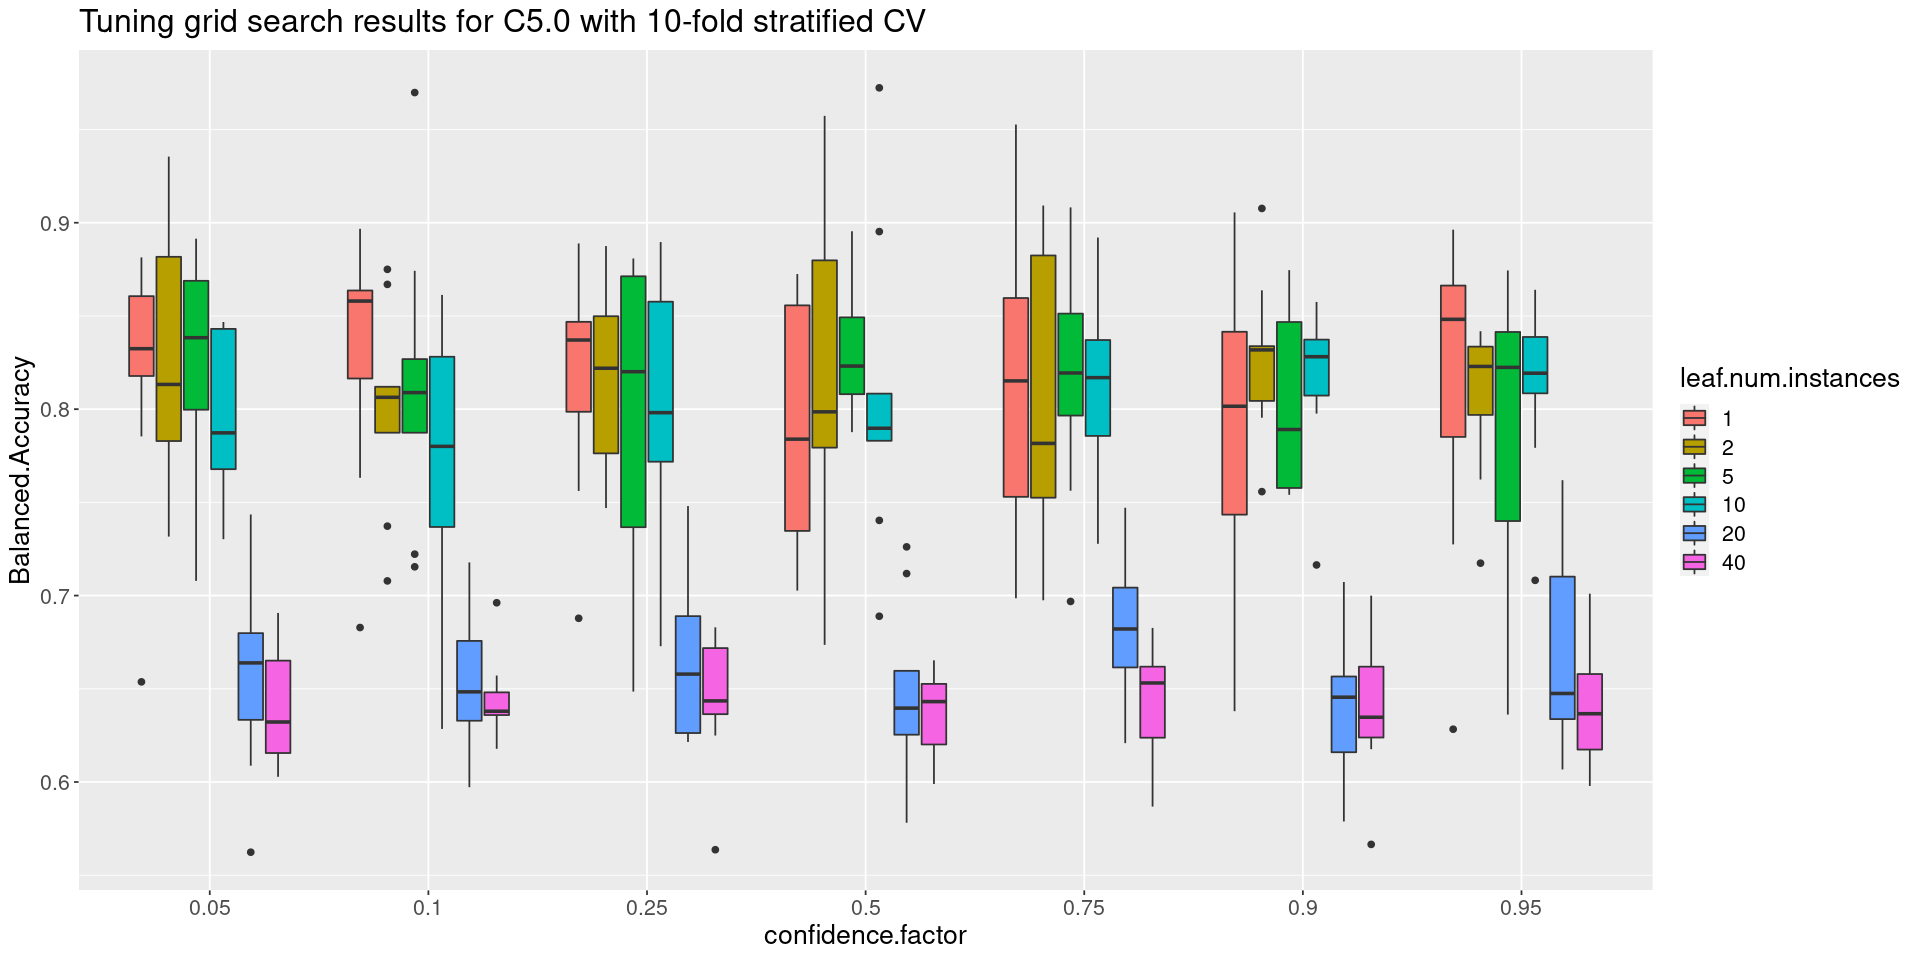

In [518]:
C50.tuned <- C50.tuning(
    seed=42, 
    data=glassData, 
    numFolds=9, 
    confidenceFactorList=c(0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95),
    leafNumInstancesList=c(1, 2, 5, 10, 20, 40),
    winnow=FALSE,
    stratify=TRUE
)

C50.tuning.boxplot(C50.tuned)

#### 3.2.2 Z selekcją cech (winnow = TRUE)

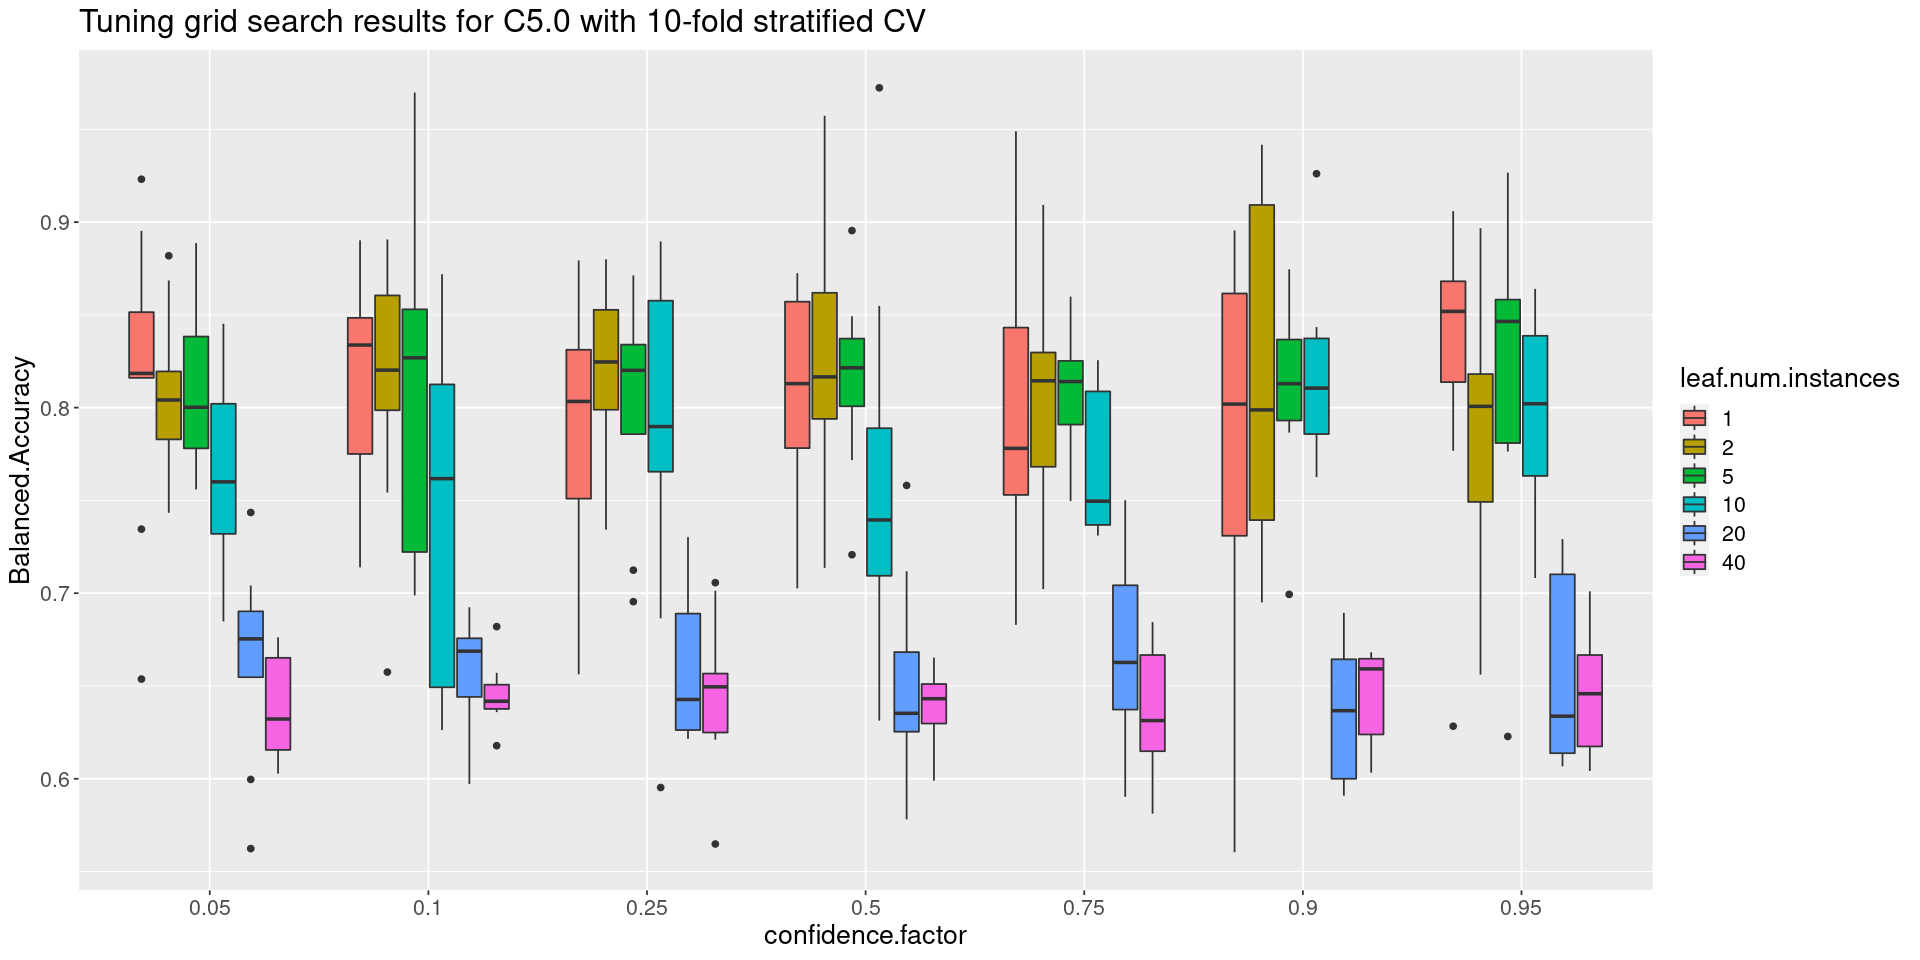

In [519]:
C50.tuned <- C50.tuning(
    seed=42, 
    data=glassData, 
    numFolds=9, 
    confidenceFactorList=c(0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95),
    leafNumInstancesList=c(1, 2, 5, 10, 20, 40),
    winnow=TRUE,
    stratify=TRUE
)

C50.tuning.boxplot(C50.tuned)

Podobnie jak C45 wartości 20 i 40 minimalnej ilości instancji wymaganych do podziału liścia, są zbyt wysokie. Nie zauważamy zbytniego pozytywnego czy nagtywnego wpływu zastosowania parametru `winnow`. Zauważamy jednak, że dla mmniejszych wartości dla obu badanych parametrów, drzewo zdaje się zachowywać minimalnie lepiej.

### 3.3 Porównanie C4.5 z C5.0 dla walidacji krzyżowej ze stratyfikacją i bez

Warning message:
“Removed 10 rows containing non-finite values (stat_boxplot).”


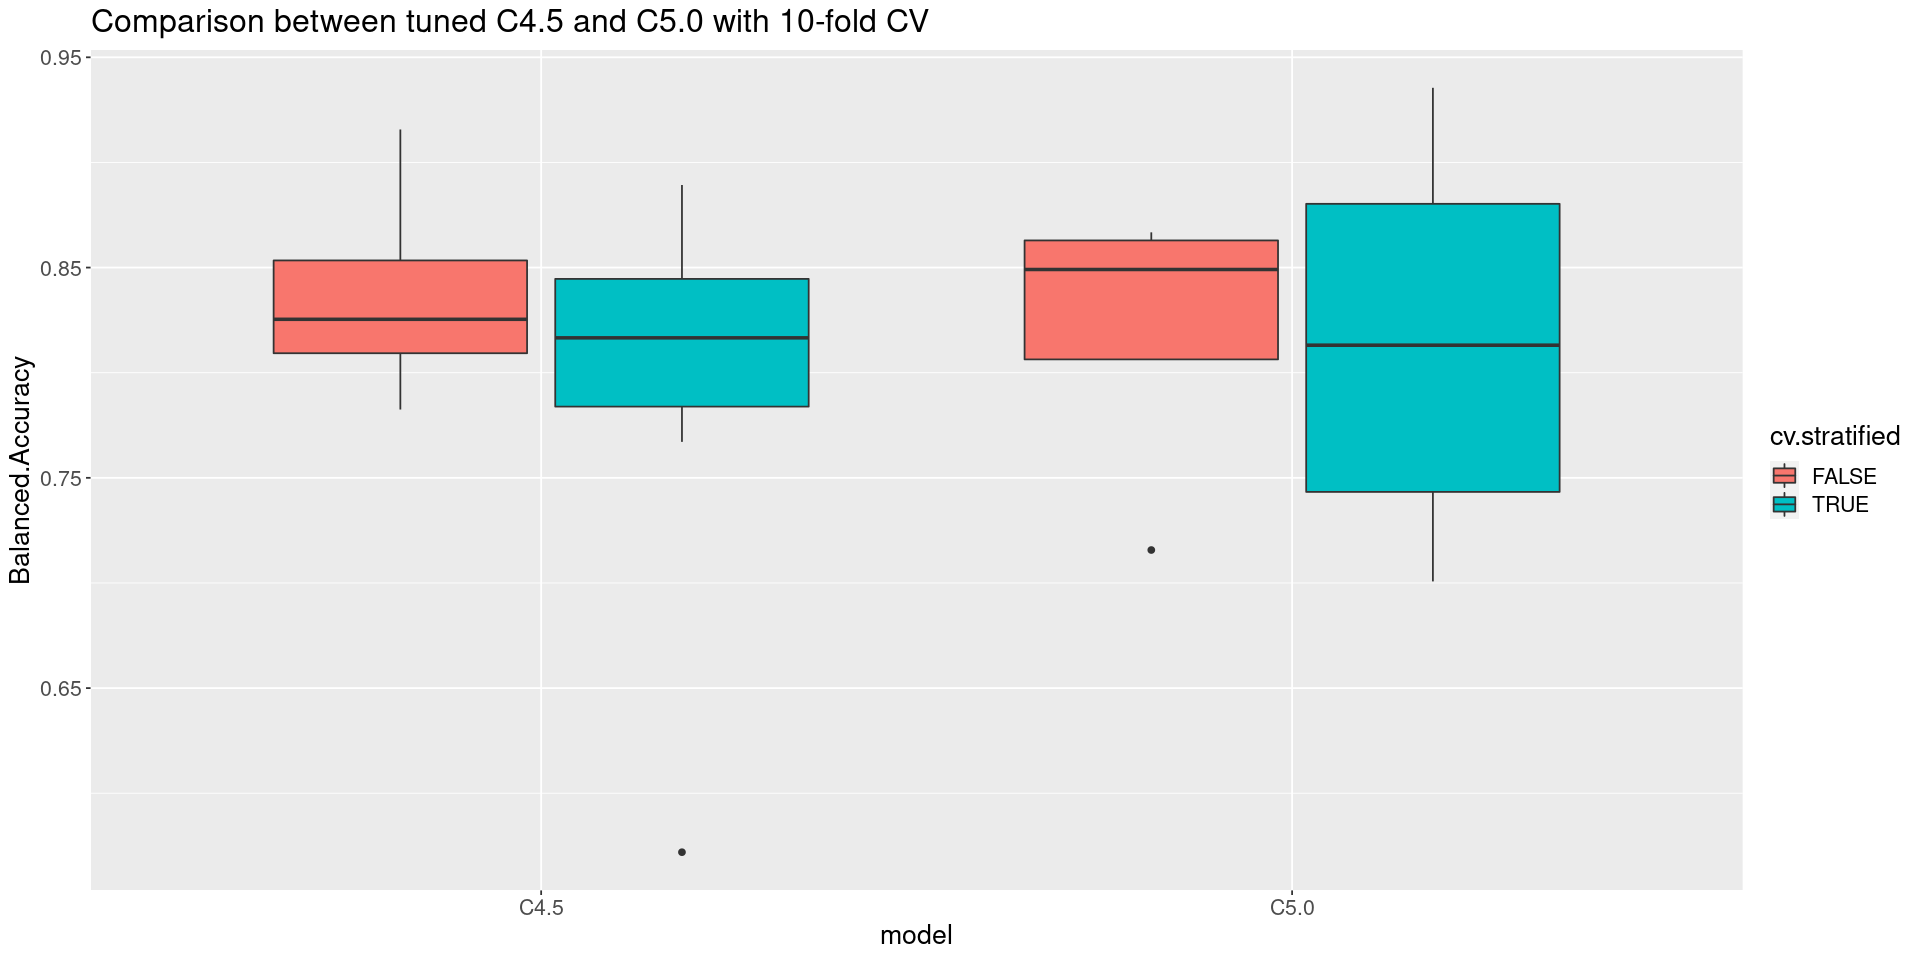

In [529]:
C45control <- Weka_control(M=1, C=0.05)
C50control <- C5.0Control(CF=0.1, minCases=1, winnow=FALSE)

results <- decision.tree.comparison(42, glassData, C45control, C50control, 9)
decision.tree.comparison.boxplot(results)

Analizując ostateczne porównanie obu metod, warto zaznaczyć, że przy braku stratyfikacji i małej ilości próbek dla jednej z klas (równej 9), nie wszystkie zbiory walidacyjne reprezentowały wszystkie klasy. W takim przypadku wartości ewaluacji były nieokreślone i zostały usunięte ze zbioru osiąganych wartości metryki (patrz warning message). Nie powinniśmy zatem kierować się ślepo wykresem, na którym walidacja nie stratyfikowana wydaje się wypadać lepiej. W tej sytuacji, gdzie zbiór ma więcej klas i są one mocno niezbalansowane, niepodważalnie wybór walidacji stratyfikowanej jest zalecany, a nawet wymagany.

Porównując metody C45 i C50 nie zauważamy znaczącej różnicy w osiąganych rezultatach.

# Pytania

### 1. Co jest modelem klasyfikacji w C4.5 (C5.0)?

Odp: Modelami klasyfikacji są drzewa decyzyjne.

### 2. Co znajduje się w liściach drzewa?

Odp: W liściach drzewa znajduje się rozkład prawdopodobieństwa klas, z którego losowana jest klasa próbki, która dostała się do tego liścia. Rozkład z reguły faworyzuje jedną konkretną klasę, a poziom faworyzacji zależy od przycięcia drzewa - im bardziej przycięte tym niepewność co do klasy próbki jest większa.

### 3. Czy przycinanie drzewa (*pruning*) jest potrzebne?

Odp: Przycinanie drzewa jest przydatne ze względu na zmniejszenie ilości parametrów modelu, a także niwelowaniu overfitting'u.

### 4. Czy drzewo może być za "duże" lub za "małe"?

Odp: Drzewo może być i za duże i za małe. Gdy jest za dużo może być zbyt zoverfittowane dla zbioru treningowego, np. każda próbka ma swóuj unikalny liść. Gdy jest za małe za to mamy problem z underfittingiem, model jest zbyt prosty żeby być w stanie opisać złożoność danych.

### 5. Dlaczego typ/rozmiar walidacji krzyżowej może mieć duży wpływ na skuteczność modelu?

Odp: Typ walidacji krzyżowej ma wpływ na skuteczność modelu szczególnie wtedy, gdy mamy do czynienia z niezbalansowanym zbiorem. Stratyfikowana walidacja pozwala poprawniej zewaluować jakość modelu, gdyż dbamy o taką samą procentową ilość próbek z każdej klasy w zbiorze treningowym i walidacyjnym. Rozmiar walidacji krzyżowej za to, wpływa na jak duży jest zbiór treningowy - im większy tym lepiej.

### 6. Czy C4.5 (C5.0) potrzebuje normalizacji / standaryzacji / dyskretyzacji danych?

Odp: Dla drzew decyzyjnych nie potrzbujemy żadnej z powyższych metod. Jest to związane z faktem, że drzewo decyzyjny uczy się poprzez thresholdowanie konkretnej cechy w węźle, dobór cechy dobiera się po entropii, która nie wymaga żadnego preprocessingu.

### 7. Czy model można przeuczyć?

Odp: Model można przeuczyć np. dla każdej próbki ze zbioru treningowego mamy unikalny liść w drzewie.

### 8. Na podstawie działania C4.5 (C5.0), wyników i dokumentacji R (parametrów) - na czym polega przewaga C5.0?

Odp: Ze opisu algorytmów (https://en.wikipedia.org/wiki/C4.5_algorithm) wynika, że metoda C5.0 jest zdecydowanie szybsza, a także zużywa mniej pamięci od C4.5. Dodatkowo C5.0 wprowadza dodatkowe usprawnienia w postaci budowy mniejszych drzew osiagających podobne rezultaty, wspiera boosting oraz wprowadza ważenie dla przypadków i opcję `winnow` do automatycznej selekcji cech. Porównując osiągnięte wyniki dla obu metod na testowanych zbiorach danych, nie zauważamy żadnej znaczącej przewagi jednej z metod nad drugą.